In [ ]:
!pip install xgboost

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # Para visualización

In [139]:
#Configuramos algunas cuestiones para favorecer la visualización
#Ignorar advertencias para un reporte más limpio
warnings.filterwarnings('ignore')
#Configuración de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# Configuración de Seaborn para los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


#  **PREPROCESAMIENTO Y ANÁLISIS EXPLORATORIO**

In [140]:
#CARGA Y PRIMERA INSPECCIÓN DE DATOS (CORREGIMOS SI HAY ERRORES)

file_name = r'D:\Lindo\UNIVERSIDAD 2025-2\DATA MINING\PROYECTO\DATA SETS\datos presupuestarios\dataset_residuos.xlsx'

try:
    df_raw = pd.read_excel(file_name)
    print(f"Archivo '{file_name}' cargado exitosamente.\n")
    print("--- 1. Primeras 5 filas (head) ---")
    print(df_raw.head())
    print("\n" + "="*80 + "\n")

    print("--- 2. Información del DataFrame (info) ---")
    df_raw.info()
    print("\n" + "="*80 + "\n")

    print("--- 3. Estadísticas Descriptivas (describe) ---")
    print(df_raw.describe(include='all'))
    print("\n" + "="*80 + "\n")

    print("--- 4. Conteo de valores nulos por columna ---")
    print(df_raw.isnull().sum())
    print("\n" + "="*80 + "\n")
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo '{file_name}'.")
    print("Asegúrate de que el archivo esté en el directorio correcto.")
    # exit()
except ImportError:
    print("Error: La librería 'openpyxl' es necesaria para leer archivos .xlsx.")
    print("Por favor, instálala usando: pip install openpyxl")
    # exit()
except Exception as e:
    print(f"Ocurrió un error al cargar o procesar el archivo: {e}")
    # exit()

Archivo 'D:\Lindo\UNIVERSIDAD 2025-2\DATA MINING\PROYECTO\DATA SETS\datos presupuestarios\dataset_residuos.xlsx' cargado exitosamente.

--- 1. Primeras 5 filas (head) ---
   UBIGEO  ANIO DEPARTAMENTO    PROVINCIA     DISTRITO REGION_NATURAL CLASIFICACION_MUNICIPAL_MEF  POB_URBANA_INEI  POB_RURAL_INEI  GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL   latitud   longitud
0   10101  2022     AMAZONAS  CHACHAPOYAS  CHACHAPOYAS          SELVA                           A            39322             952                             0.56               7996.41                       326.064814               889.677360                0.020000 -6.247736 -77.856492
1   10102  2022     AMAZONAS  CHACHAPOYAS     ASUNCION          SELVA                           F              132             144                             0.74                 35.71                       289.773550               651.086957        

In [141]:
#verificamos si hay duplicados
# 1. Eliminar duplicados
duplicados_iniciales = df_raw.duplicated().sum()
if duplicados_iniciales > 0:
    df_raw.drop_duplicates(inplace=True)
    print(f"Se eliminaron {duplicados_iniciales} filas duplicadas.")

In [142]:
# 2. Confirmar hipótesis de AÑO (2019-2022) 
n_unique_ubigeo = df_raw['UBIGEO'].nunique()
n_total_rows = len(df_raw)
avg_rows_per_ubigeo = n_total_rows / n_unique_ubigeo

print(f"Total de filas limpias: {n_total_rows}")
print(f"Distritos únicos (UBIGEO): {n_unique_ubigeo}")
print(f"Filas promedio por distrito: {avg_rows_per_ubigeo:.2f} (Confirma hipótesis de 4 años)") ##ESTE VALOR SE CORRESPONDE CON LA CANTIDAD DE DISTRITOS QUE HAY EN PERU AL 2025

Total de filas limpias: 7488
Distritos únicos (UBIGEO): 1872
Filas promedio por distrito: 4.00 (Confirma hipótesis de 4 años)


In [143]:
# 3. Agregar datos (Promedio del periodo por distrito)
categorical_cols = ['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'REGION_NATURAL', 'CLASIFICACION_MUNICIPAL_MEF', 'latitud', 'longitud']
numerical_cols = [
    'POB_URBANA_INEI',
    'POB_RURAL_INEI',
    'GENERACION_PER_CAPITA_MUNICIPAL',
    'GENERACION_MUN_TANIO',
    'PROM_GASTO_ULTIMO_MES_ALIMENTOS',
    'PROM_INGRESO_ULTIMO_MES',
    'FUNCION_NOMBRE_%_TOTAL'
]

aggregations = {col: 'mean' for col in numerical_cols}
for col in categorical_cols:
    aggregations[col] = 'first' # 'first' asume que estos valores son constantes para cada UBIGEO

df_agg = df_raw.groupby('UBIGEO').agg(aggregations).reset_index()

# 4. Feature Engineering: Crear POB_TOTAL_INEI
df_agg['POB_TOTAL_INEI'] = df_agg['POB_URBANA_INEI'] + df_agg['POB_RURAL_INEI']

print(f"\nDataFrame Agregado (1 fila por distrito): {df_agg.shape}")
print(df_agg.head())


DataFrame Agregado (1 fila por distrito): (1872, 16)
   UBIGEO  POB_URBANA_INEI  POB_RURAL_INEI  GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL DEPARTAMENTO    PROVINCIA     DISTRITO REGION_NATURAL CLASIFICACION_MUNICIPAL_MEF   latitud   longitud  POB_TOTAL_INEI
0   10101          38367.0          854.50                            0.645             8980.8325                       318.058247               890.580156                0.043929     AMAZONAS  CHACHAPOYAS  CHACHAPOYAS          SELVA                           A -6.247736 -77.856492        39221.50
1   10102            138.5          139.50                            0.750               38.1000                       290.514953               660.584426                0.071409     AMAZONAS  CHACHAPOYAS     ASUNCION          SELVA                           F -5.996135 -77.743201          278.00
2   10103            306.0          871.25       

In [83]:
df_agg #TIENE EL PROMEDIO ENTRE LOS 4 AÑOS PARA LAS VARIABLES. SE RESERVA POR SI SE REQUIERE SU USO MÁS ADELANTE 

UBIGEO  POB_URBANA_INEI  POB_RURAL_INEI  GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL DEPARTAMENTO    PROVINCIA                DISTRITO REGION_NATURAL CLASIFICACION_MUNICIPAL_MEF    latitud   longitud  POB_TOTAL_INEI
0      10101         38367.00          854.50                           0.6450             8980.8325                       318.058247               890.580156                0.043929     AMAZONAS  CHACHAPOYAS             CHACHAPOYAS          SELVA                           A  -6.247736 -77.856492        39221.50
1      10102           138.50          139.50                           0.7500               38.1000                       290.514953               660.584426                0.071409     AMAZONAS  CHACHAPOYAS                ASUNCION          SELVA                           F  -5.996135 -77.743201          278.00
2      10103           306.00          871.25                           0.6300               70.1650                       286.245651               631.129873                0.031470     AMAZONAS  CHACHAPOYAS                  BALSAS         SIERRA                           G  -6.807839 -77.949422         1177.25
3      10104           455.50          247.00                           0.6300              104.4775                       320.793045               855.827737                0.033414     AMAZONAS  CHACHAPOYAS                   CHETO         SIERRA                           F  -6.297970 -77.677166          702.50
4      10105           161.50          425.75                           0.6300               37.0300                       288.237105               639.810399                0.031545     AMAZONAS  CHACHAPOYAS               CHILIQUIN         SIERRA                           G  -6.078207 -77.755868          587.25
...      ...              ...             ...                              ...                   ...                              ...                      ...                     ...          ...          ...                     ...            ...                         ...        ...        ...             ...
1867  250302          7695.50         4539.00                           0.6825             1923.3725                       305.809596               723.324352                0.051956      UCAYALI   PADRE ABAD                 IRAZOLA          SELVA                           F  -8.950516 -75.279918        12234.50
1868  250303          4887.75         5501.25                           0.7925             1416.4300                       284.487798               647.367008                0.077923      UCAYALI   PADRE ABAD                CURIMANA          SELVA                           F  -8.417380 -75.297114        10389.00
1869  250304          5208.50         5464.25                           0.8200             1557.1150                       283.565928               655.967308                0.074132      UCAYALI   PADRE ABAD                 NESHUYA          SELVA                           F  -8.641299 -75.049031        10672.75
1870  250305          4760.25         1451.75                           0.6725             1176.7175                       312.897414               788.907927                0.049662      UCAYALI   PADRE ABAD  ALEXANDER VON HUMBOLDT          SELVA                           E  -8.824928 -75.048021         6212.00
1871  250401          1368.00         1920.00                           0.7500              376.1150                       283.218197               621.287209                0.070999      UCAYALI        PURUS                   PURUS          SELVA                           B -10.373495 -71.582316         3288.00

[1872 rows x 16 columns]

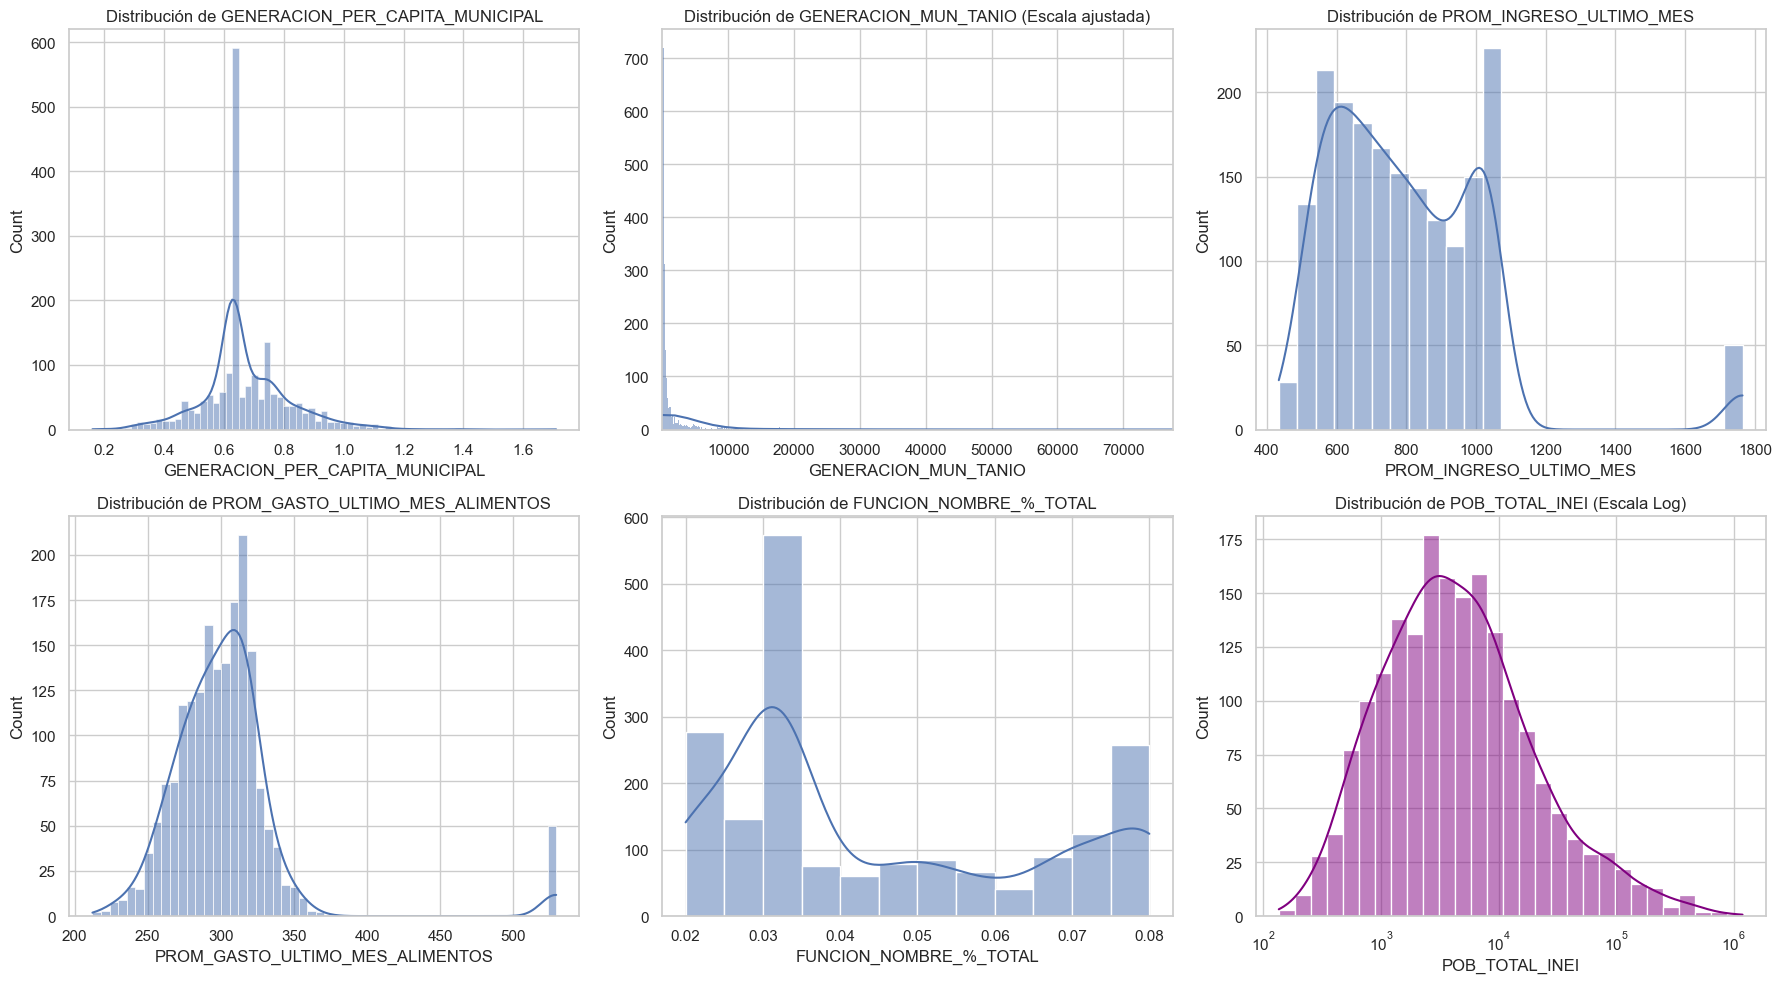

In [84]:
#ANALICEMOS LA DISTRIBUCIÓN DE LAS VARIABLES DE TODOS LOS DISTRITOS
num_vars_to_plot = [
    'GENERACION_PER_CAPITA_MUNICIPAL',
    'GENERACION_MUN_TANIO',
    'PROM_INGRESO_ULTIMO_MES',
    'PROM_GASTO_ULTIMO_MES_ALIMENTOS',
    'FUNCION_NOMBRE_%_TOTAL',
    'POB_TOTAL_INEI'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(num_vars_to_plot):
    ax = axes[i]

    #CORRECCIÓN: Escala más pequeña para GENERACION_MUN_TANIO
    if var == 'GENERACION_MUN_TANIO':
        # Convertir a numérico por seguridad
        df_agg[var] = pd.to_numeric(df_agg[var], errors='coerce')

        # Zoom automático para mejorar visualización
        xmin, xmax = df_agg[var].quantile([0.01, 0.99])
        
        sns.histplot(data=df_agg, x=var, ax=ax, kde=True)
        ax.set_xlim(xmin, xmax)   # ← Escala más pequeña aquí
        ax.set_title(f'Distribución de {var} (Escala ajustada)')
        continue

    if var == 'POB_TOTAL_INEI':
        sns.histplot(data=df_agg, x=var, ax=ax, kde=True, color='purple', log_scale=True)
        ax.set_title(f'Distribución de {var} (Escala Log)')
    else:
        sns.histplot(data=df_agg, x=var, ax=ax, kde=True)
        ax.set_title(f'Distribución de {var}')

plt.tight_layout()
plt.savefig('univariate_histograms.png')
plt.show() #LA DISTRIBUCIÓN DE LA VARIABLE DE GENERACIÓN MUNICIPAL POR AÑO REFLEJA QUE HAY MUNICIPALIDADES QUE GENERAN MUCHO MENOS RESIDUOS QUE OTRAS.
#SE PROCEDE AL ANALISIS DE VALORES ATIPICOS PARA VERIFICAR 

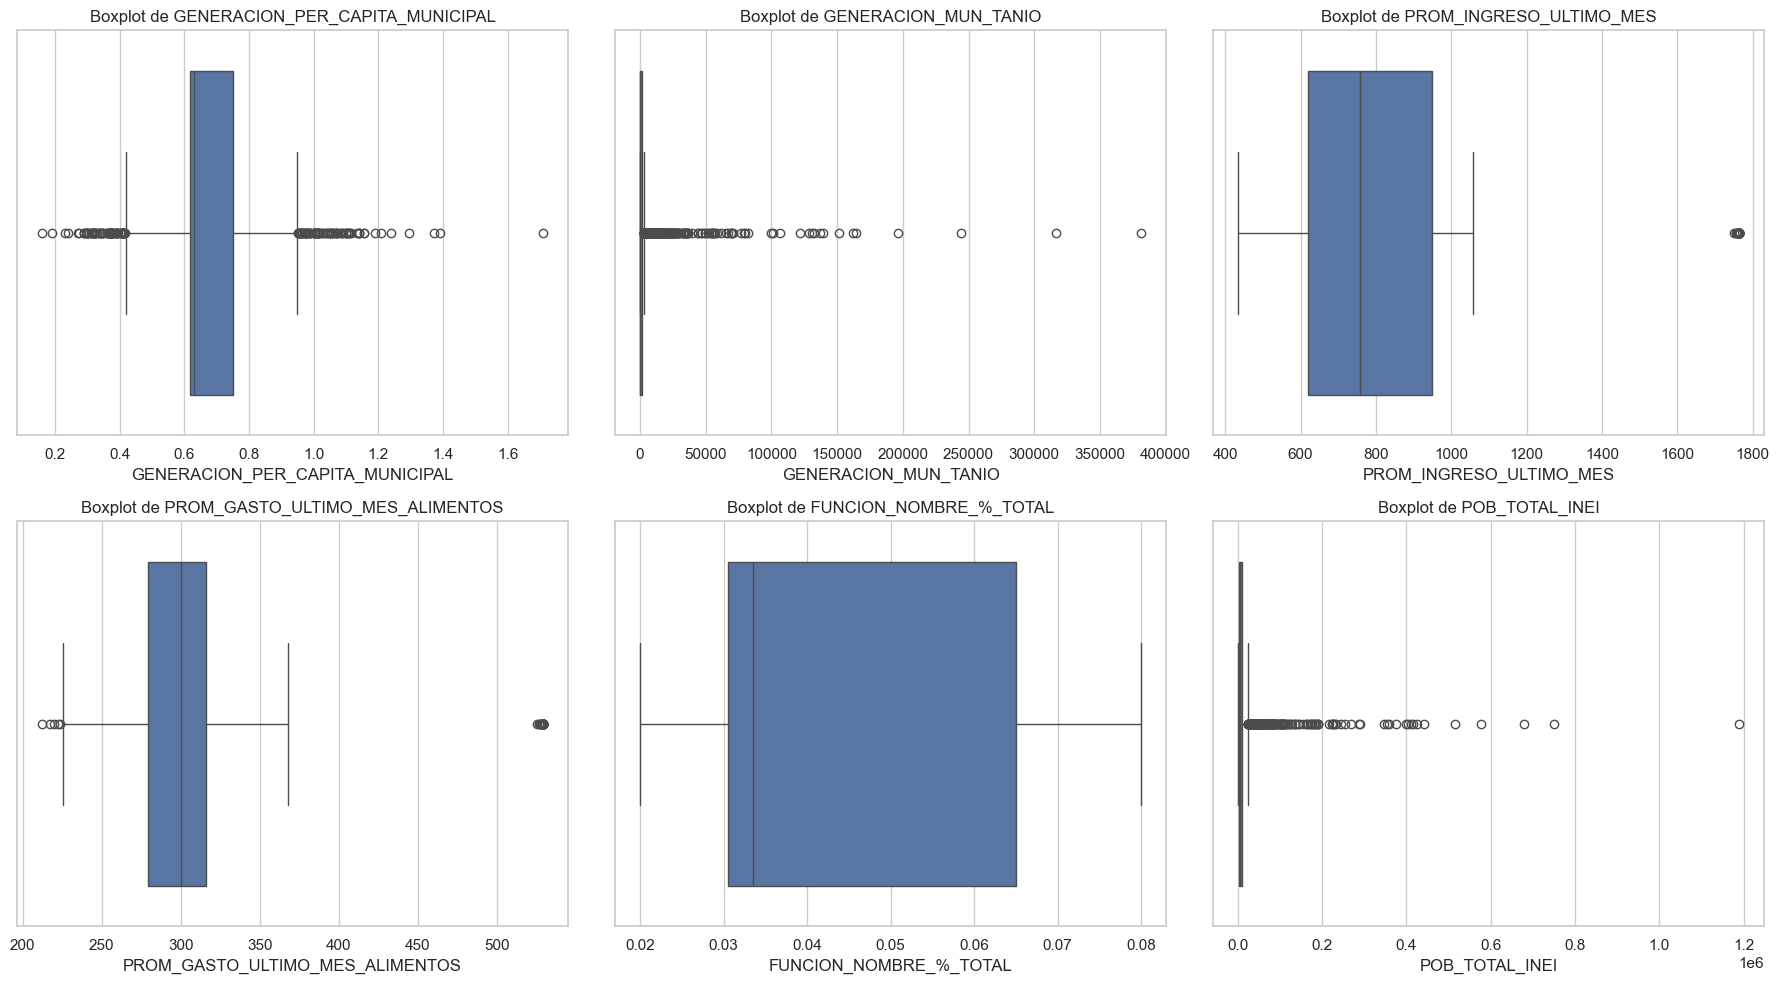

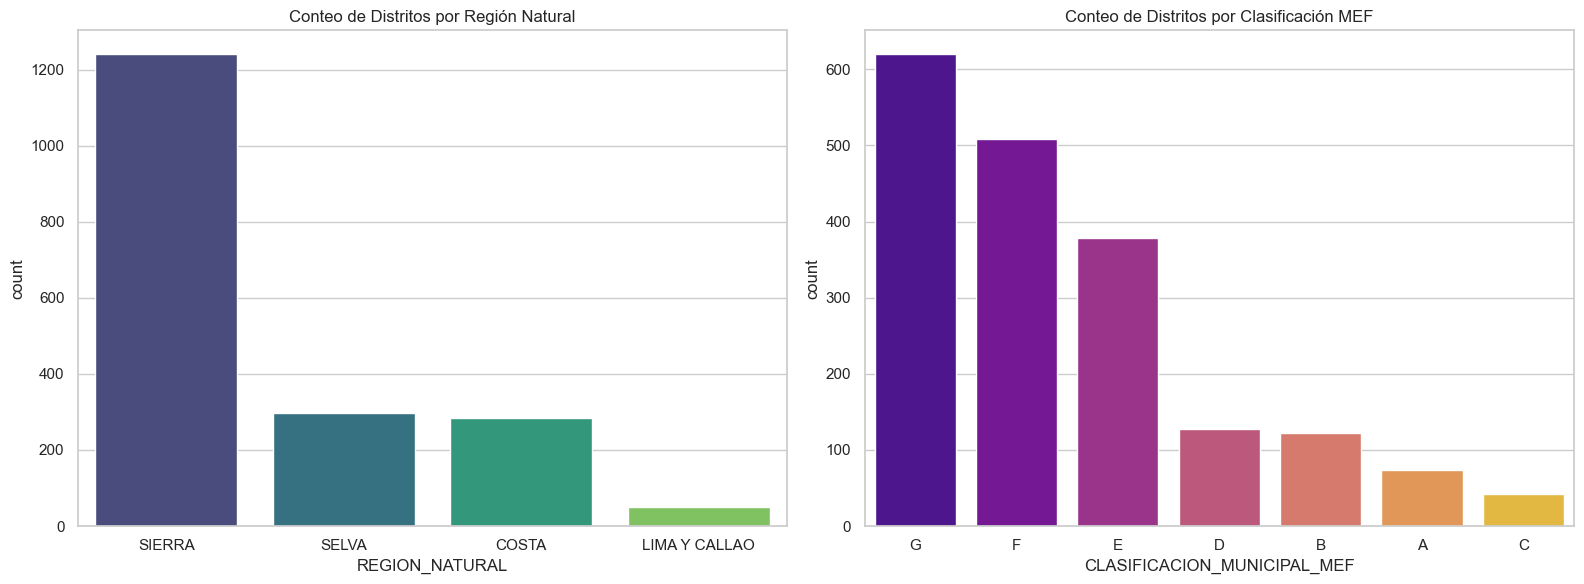

In [85]:
#ANALICEMOS VALORES ATIPICOS DE LAS VARIABLES DE TODOS LOS DISTRITOS
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, var in enumerate(num_vars_to_plot):
    ax = axes[i]
    sns.boxplot(data=df_agg, x=var, ax=ax)
    ax.set_title(f'Boxplot de {var}')
plt.tight_layout()
plt.savefig('univariate_boxplots.png')
plt.show()

# 4.3 Distribución de Variables Categóricas (Gráficos de Barras)
cat_vars_to_plot = ['REGION_NATURAL', 'CLASIFICACION_MUNICIPAL_MEF']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=df_agg, x='REGION_NATURAL', ax=axes[0], order=df_agg['REGION_NATURAL'].value_counts().index, palette='viridis')
axes[0].set_title('Conteo de Distritos por Región Natural')
sns.countplot(data=df_agg, x='CLASIFICACION_MUNICIPAL_MEF', ax=axes[1], order=df_agg['CLASIFICACION_MUNICIPAL_MEF'].value_counts().index, palette='plasma')
axes[1].set_title('Conteo de Distritos por Clasificación MEF')
plt.tight_layout()
plt.savefig('univariate_barplots.png')
plt.show() #SOSPECHAMOS QUE HAY DEMASIADOS VALORES ATIPICOS GENERADOS POR LOS DISTRITOS DE LA REGION_NATURAL LIMA Y CALLAO 

In [144]:
df_lima_callao

UBIGEO  POB_URBANA_INEI  POB_RURAL_INEI  GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL DEPARTAMENTO PROVINCIA                    DISTRITO REGION_NATURAL CLASIFICACION_MUNICIPAL_MEF    latitud   longitud  POB_TOTAL_INEI
689    70101        516183.50            0.00                           0.8725           164482.3575                       529.350000              1764.500000                0.074449       CALLAO    CALLAO                      CALLAO  LIMA Y CALLAO                           A -12.016752 -77.121133       516183.50
690    70102         80848.25            0.00                           0.8500            25077.6050                       529.350000              1764.500000                0.080000       CALLAO    CALLAO                  BELLAVISTA  LIMA Y CALLAO                           D -12.060006 -77.109903        80848.25
691    70103         46553.75            0.00                           1.0500            17854.1900                       529.350000              1764.500000                0.080000       CALLAO    CALLAO  CARMEN DE LA LEGUA REYNOSO  LIMA Y CALLAO                           D -12.042885 -77.090418        46553.75
692    70104         64433.00            0.00                           1.0000            23525.0825                       529.350000              1764.500000                0.080000       CALLAO    CALLAO                    LA PERLA  LIMA Y CALLAO                           D -12.070277 -77.116098        64433.00
693    70105          3915.50            0.00                           0.9225             1322.4250                       529.350000              1764.500000                0.080000       CALLAO    CALLAO                    LA PUNTA  LIMA Y CALLAO                           D -12.071695 -77.162783         3915.50
694    70106        374777.75            0.00                           0.7800           106473.9500                       529.350000              1764.500000                0.078917       CALLAO    CALLAO                  VENTANILLA  LIMA Y CALLAO                           D -11.879125 -77.130864       374777.75
695    70107         52911.75            0.00                           0.6600            12691.2600                       529.350000              1764.500000                0.044108       CALLAO    CALLAO                     MI PERU  LIMA Y CALLAO                           D -11.854339 -77.120556        52911.75
1278  150101        267808.50            0.00                           1.0250            99854.7275                       529.350000              1764.500000                0.080000         LIMA      LIMA                        LIMA  LIMA Y CALLAO                           A -12.051032 -77.048874       267808.50
1279  150102         84400.75            0.00                           0.9400            28963.5725                       529.350000              1764.500000                0.080000         LIMA      LIMA                       ANCON  LIMA Y CALLAO                           C -11.702534 -77.095807        84400.75
1280  150103        678537.00            0.00                           0.9900           244127.9175                       529.350000              1764.500000                0.080000         LIMA      LIMA                         ATE  LIMA Y CALLAO                           C -12.032571 -76.877480       678537.00
1281  150104         36081.75            0.00                           0.6650             8747.8800                       529.350000              1764.500000                0.045598         LIMA      LIMA                    BARRANCO  LIMA Y CALLAO                           C -12.144030 -77.020863        36081.75
1282  150105         93665.00            0.00                           1.0725            36640.1900                       529.350000              1764.500000                0.080000         LIMA      LIMA                     

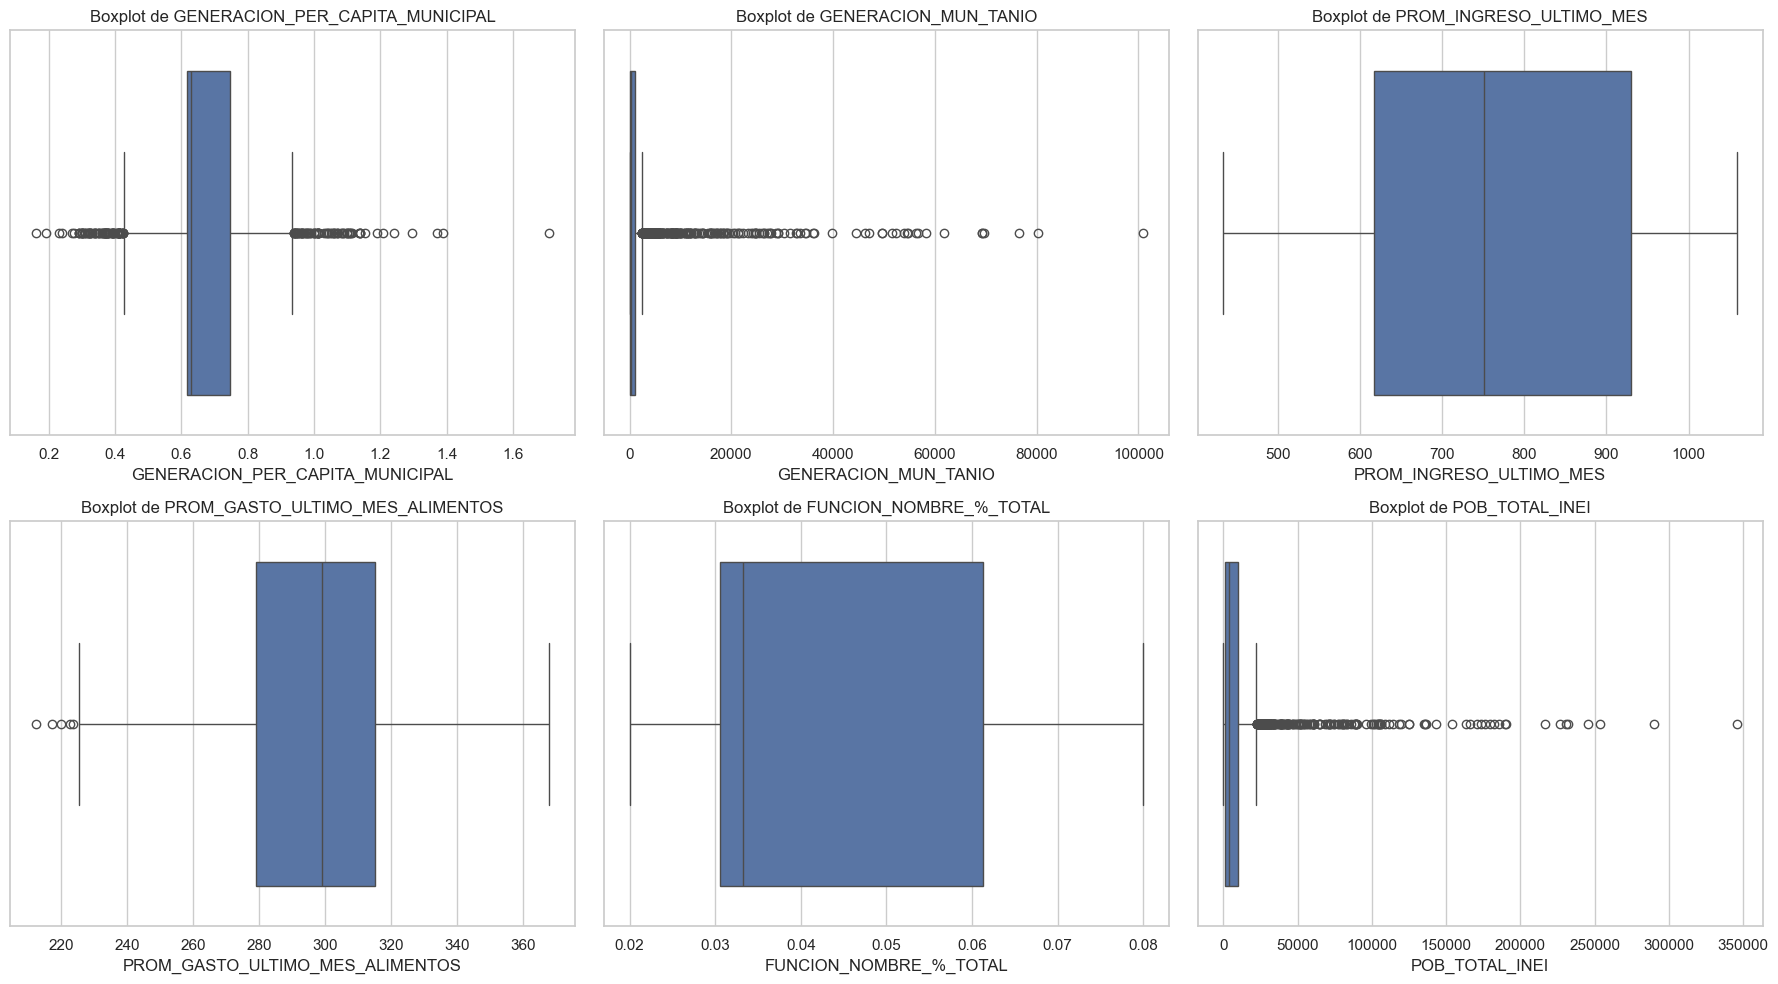

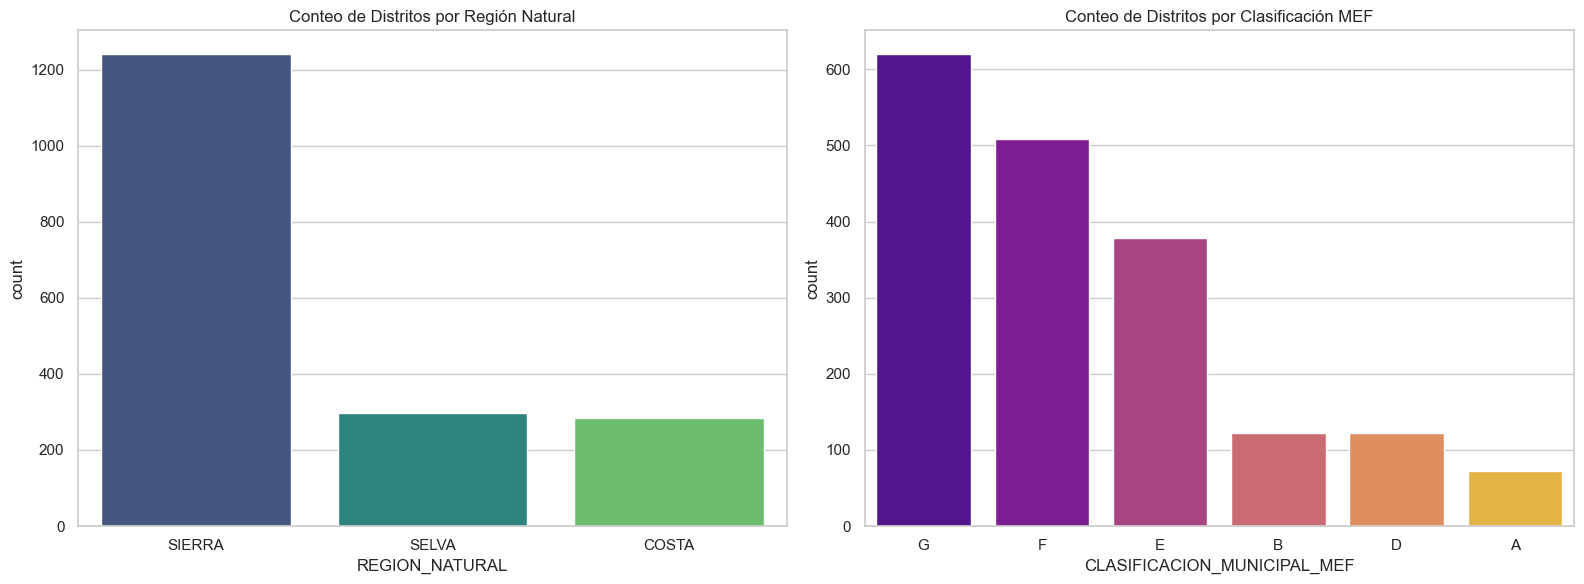

In [86]:
#ANALICEMOS VALORES ATIPICOS DE LAS VARIABLES DE TODOS LOS DISTRITOS MENOS LIMA Y CALLAO 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, var in enumerate(num_vars_to_plot):
    ax = axes[i]
    sns.boxplot(data=df_resto, x=var, ax=ax)
    ax.set_title(f'Boxplot de {var}')
plt.tight_layout()
plt.savefig('univariate_boxplots.png')
plt.show()

# 4.3 Distribución de Variables Categóricas (Gráficos de Barras)
cat_vars_to_plot = ['REGION_NATURAL', 'CLASIFICACION_MUNICIPAL_MEF']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=df_resto, x='REGION_NATURAL', ax=axes[0], order=df_resto['REGION_NATURAL'].value_counts().index, palette='viridis')
axes[0].set_title('Conteo de Distritos por Región Natural')
sns.countplot(data=df_resto, x='CLASIFICACION_MUNICIPAL_MEF', ax=axes[1], order=df_resto['CLASIFICACION_MUNICIPAL_MEF'].value_counts().index, palette='plasma')
axes[1].set_title('Conteo de Distritos por Clasificación MEF')
plt.tight_layout()
plt.savefig('univariate_barplots.png')
plt.show()

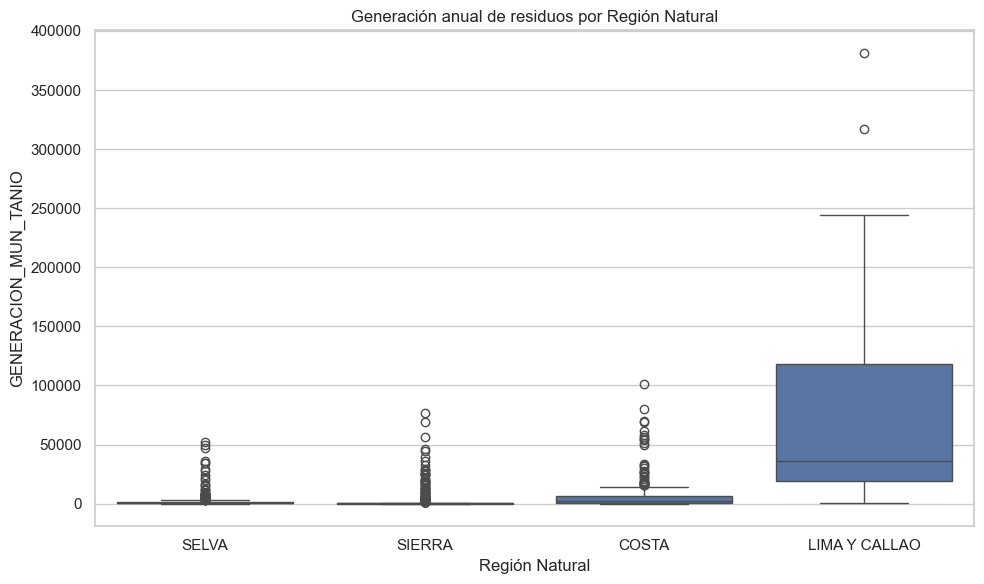

In [87]:
#GRAFICAMOS LA GENERACIÓN ANUAL POR REGION NATURAL 
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_agg,
    x='REGION_NATURAL',
    y='GENERACION_MUN_TANIO'
)
plt.title("Generación anual de residuos por Región Natural")
plt.xlabel("Región Natural")
plt.ylabel("GENERACION_MUN_TANIO")
plt.tight_layout()
plt.show() #CONFIRMAMOS LA SOSPECHA, PARA CONTINUAR CON EL ANALISIS ES IMPORTANTE SEPARAR EL ANALISIS EN DOS 
#UN DATASET QUE TENGA INFORMACION SOBRE LOS DISTRITOS DE LIMA Y CALLAO Y OTRO DATASET QUE TENGA INFORMACION SOBRE EL RESTO 

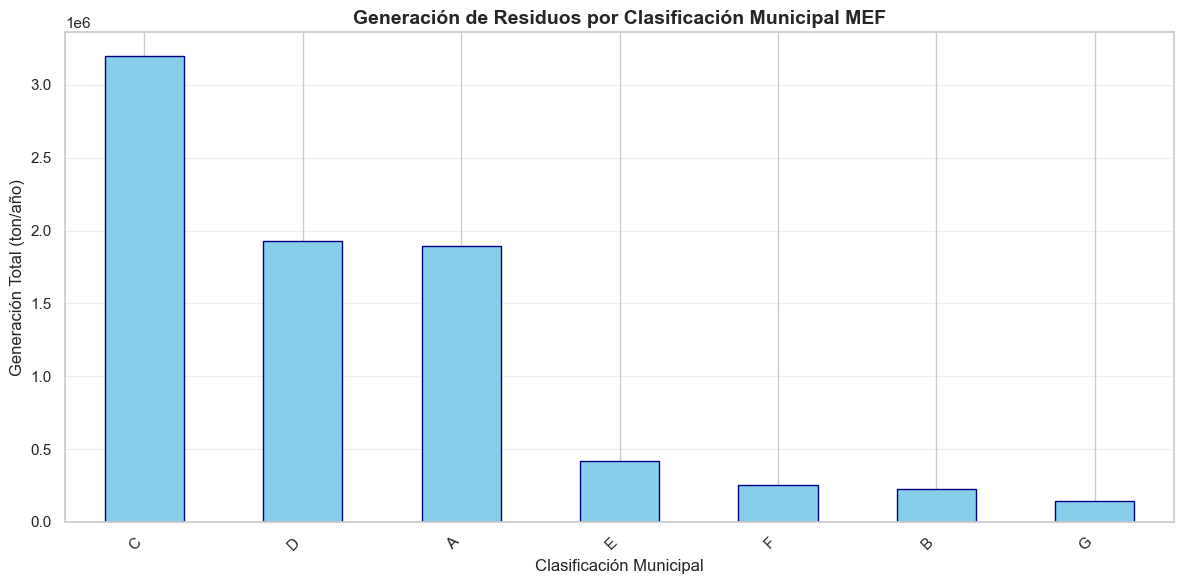

In [88]:
generacion_por_tipo = df_agg.groupby('CLASIFICACION_MUNICIPAL_MEF')['GENERACION_MUN_TANIO'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
generacion_por_tipo.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('Generación de Residuos por Clasificación Municipal MEF', fontsize=14, fontweight='bold')
plt.xlabel('Clasificación Municipal', fontsize=12)
plt.ylabel('Generación Total (ton/año)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [89]:
# Filtrar exactamente el valor "LIMA Y CALLAO"
df_lima_callao = df_agg[df_agg["REGION_NATURAL"] == "LIMA Y CALLAO"].copy()

# Filtrar el resto
df_resto = df_agg[df_agg["REGION_NATURAL"] != "LIMA Y CALLAO"].copy()

print("Distritos en LIMA Y CALLAO:", len(df_lima_callao))
print("Distritos en el resto del país:", len(df_resto))

Distritos en LIMA Y CALLAO: 50
Distritos en el resto del país: 1822


Generando boxplots...


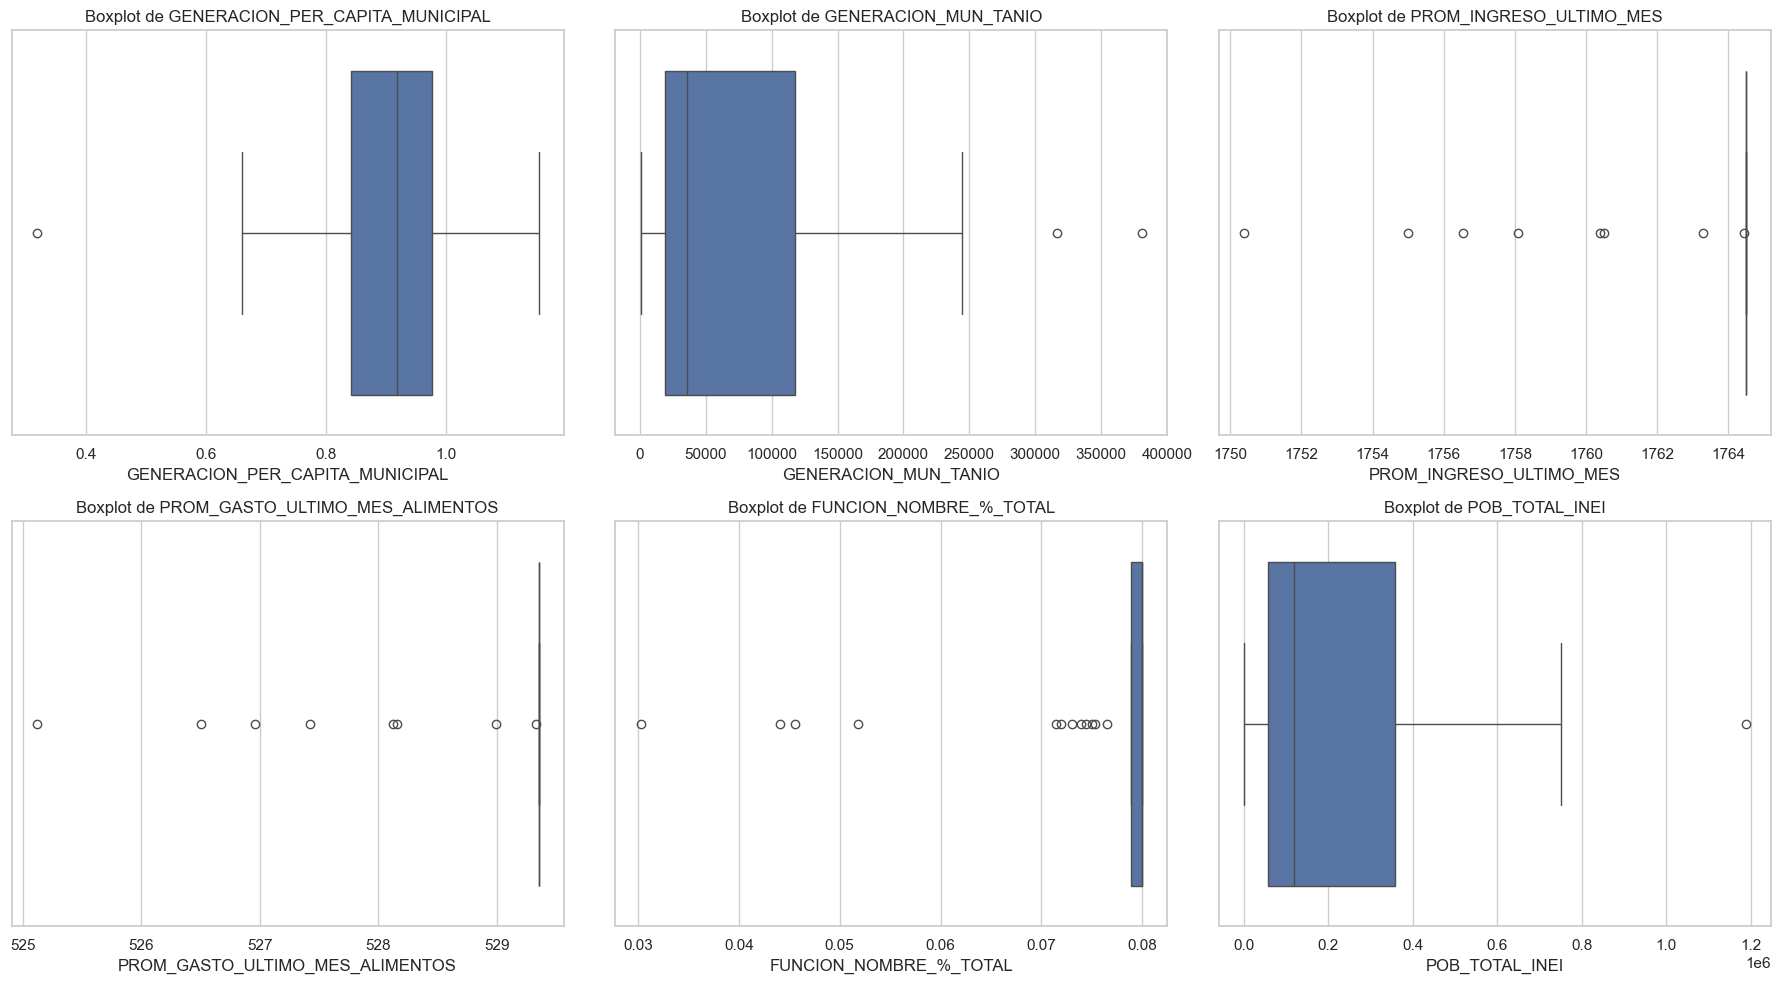

Generando gráficos de barras categóricos...


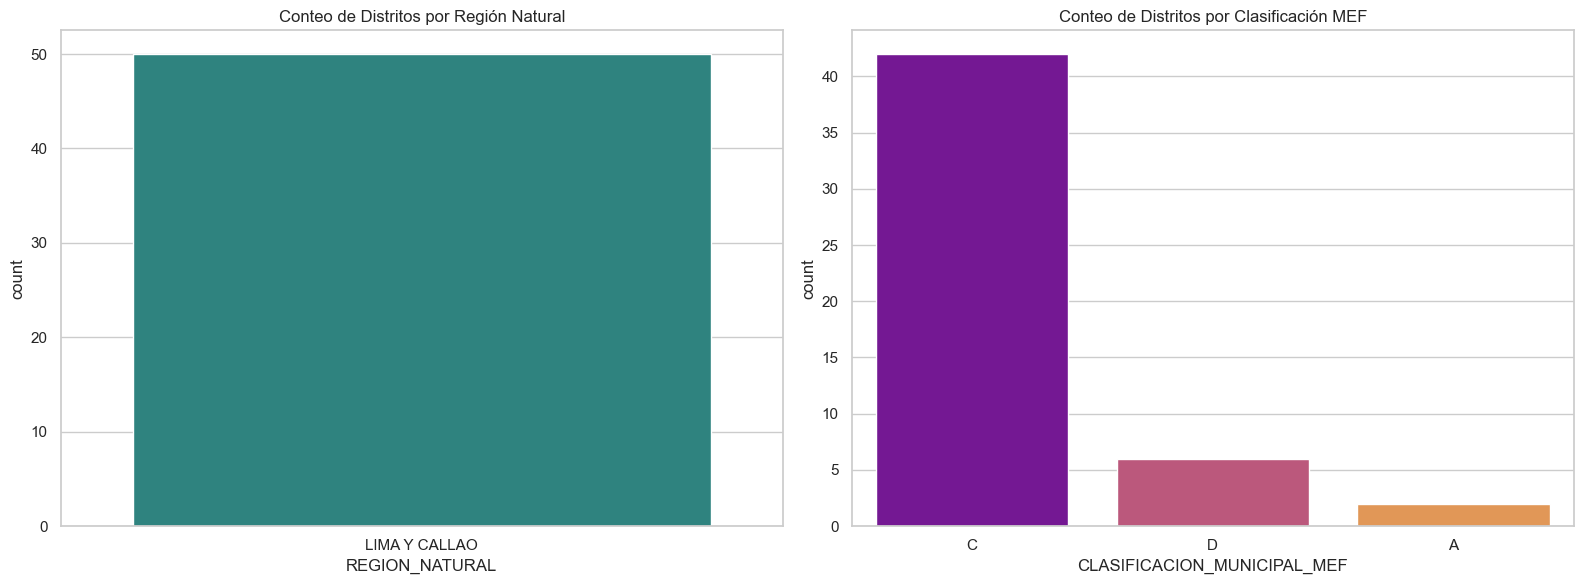

In [90]:
#ANALICEMOS VALORES ATIPICOS EN LOS DISTRITOS DE LIMA Y CALLAO UNICAMENTE 
print("Generando boxplots...")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, var in enumerate(num_vars_to_plot):
    ax = axes[i]
    sns.boxplot(data=df_lima_callao, x=var, ax=ax)
    ax.set_title(f'Boxplot de {var}')
plt.tight_layout()
plt.savefig('univariate_boxplots.png')
plt.show()

# 4.3 Distribución de Variables Categóricas (Gráficos de Barras)
print("Generando gráficos de barras categóricos...")
cat_vars_to_plot = ['REGION_NATURAL', 'CLASIFICACION_MUNICIPAL_MEF']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=df_lima_callao, x='REGION_NATURAL', ax=axes[0], order=df_lima_callao['REGION_NATURAL'].value_counts().index, palette='viridis')
axes[0].set_title('Conteo de Distritos por Región Natural')
sns.countplot(data=df_lima_callao, x='CLASIFICACION_MUNICIPAL_MEF', ax=axes[1], order=df_lima_callao['CLASIFICACION_MUNICIPAL_MEF'].value_counts().index, palette='plasma')
axes[1].set_title('Conteo de Distritos por Clasificación MEF')
plt.tight_layout()
plt.savefig('univariate_barplots.png')
plt.show()

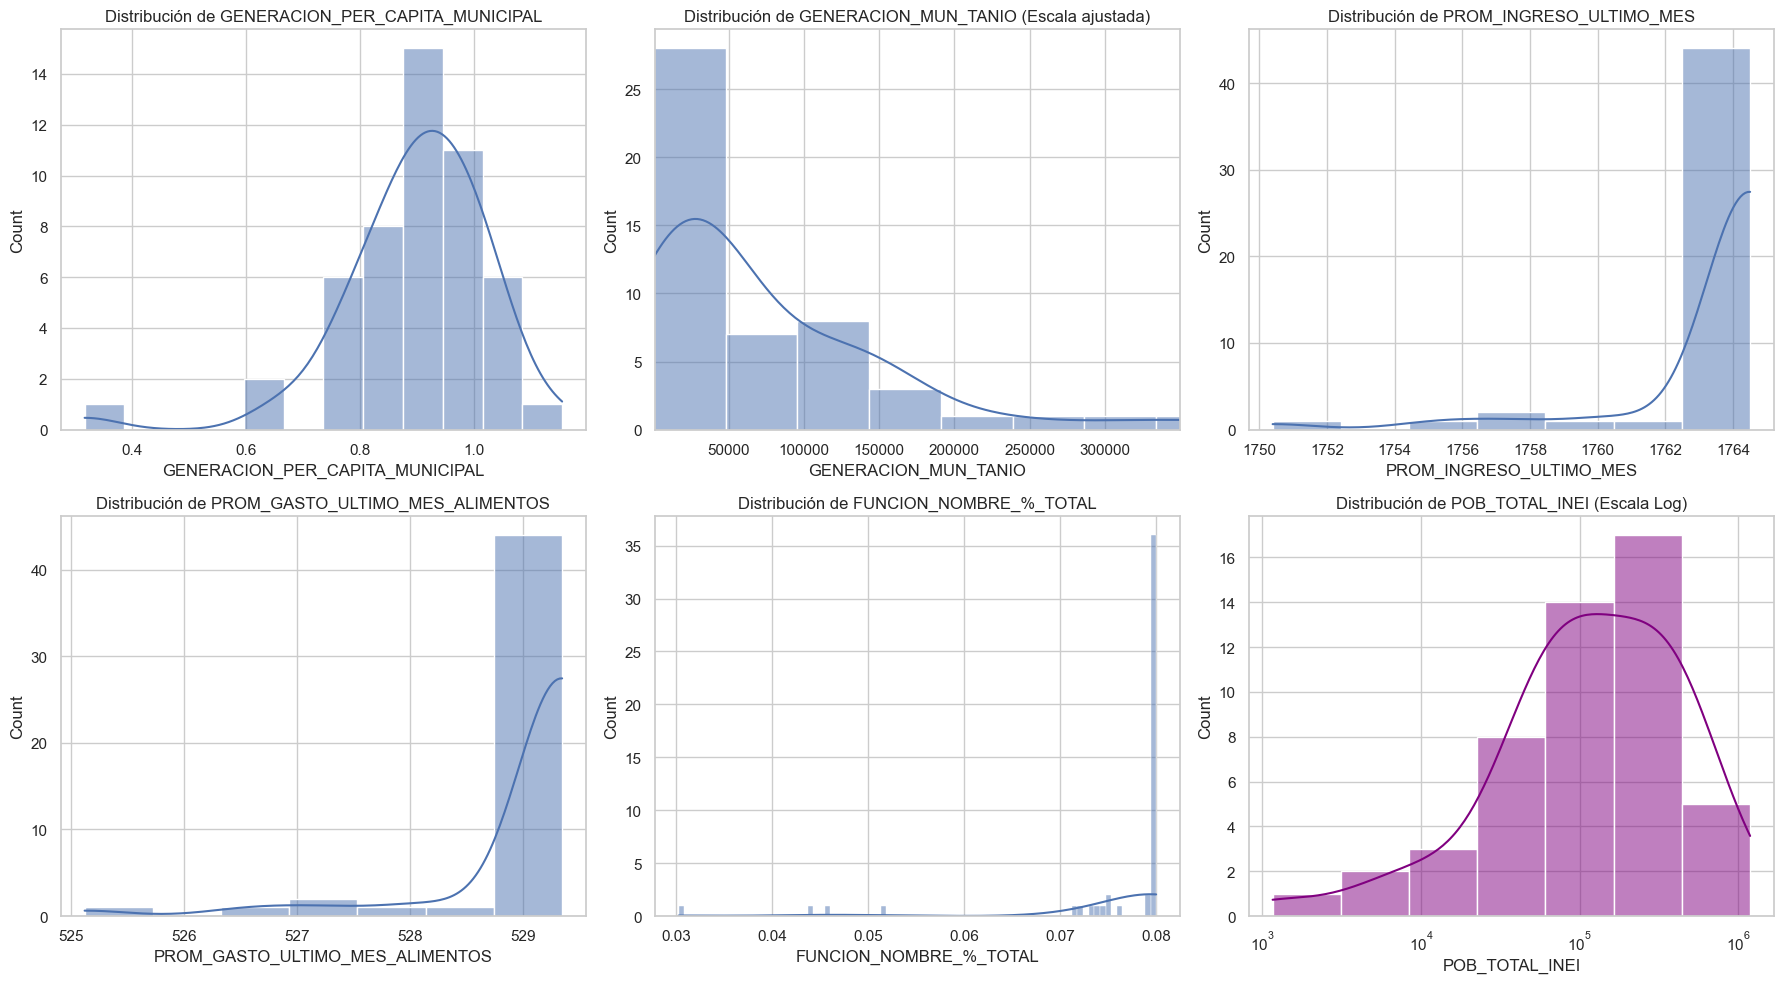

In [91]:
#ANALICEMOS LAS DISTRIBUCIONES DE LAS VARIABLES EN LOS DISTRITOS DE LIMA Y CALLAO UNICAMENTE 
num_vars_to_plot = [
    'GENERACION_PER_CAPITA_MUNICIPAL',
    'GENERACION_MUN_TANIO',
    'PROM_INGRESO_ULTIMO_MES',
    'PROM_GASTO_ULTIMO_MES_ALIMENTOS',
    'FUNCION_NOMBRE_%_TOTAL',
    'POB_TOTAL_INEI'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(num_vars_to_plot):
    ax = axes[i]

    #CORRECCIÓN: Escala más pequeña para GENERACION_MUN_TANIO
    if var == 'GENERACION_MUN_TANIO':
        # Convertir a numérico por seguridad
        df_lima_callao[var] = pd.to_numeric(df_lima_callao[var], errors='coerce')

        # Zoom automático para mejorar visualización
        xmin, xmax = df_lima_callao[var].quantile([0.01, 0.99])
        
        sns.histplot(data=df_lima_callao, x=var, ax=ax, kde=True)
        ax.set_xlim(xmin, xmax)   # ← Escala más pequeña aquí
        ax.set_title(f'Distribución de {var} (Escala ajustada)')
        continue

    if var == 'POB_TOTAL_INEI':
        sns.histplot(data=df_lima_callao, x=var, ax=ax, kde=True, color='purple', log_scale=True)
        ax.set_title(f'Distribución de {var} (Escala Log)')
    else:
        sns.histplot(data=df_lima_callao, x=var, ax=ax, kde=True)
        ax.set_title(f'Distribución de {var}')

plt.tight_layout()
plt.savefig('univariate_histograms.png')
plt.show() #EFECTIVAMENTE, AHORA SE PUEDE VISUALIZAR DE MEJOR MANERA SI ANALIZAMOS DE FORMA AISLADA A LOS DISTRITOS DE LIMA Y CALLAO, PUES TIENEN VALORES
#DE GENERACIÓN MUCHO MÁS ALTOS QUE EL RESTO

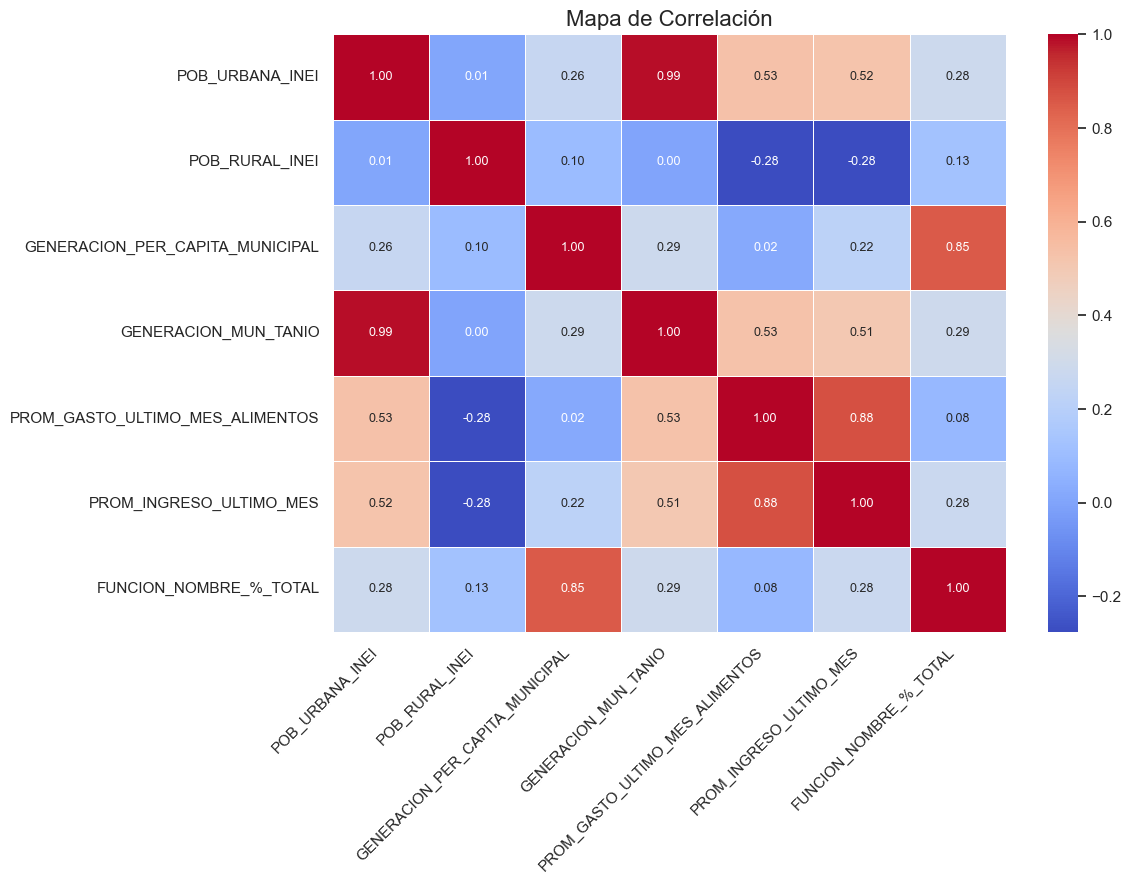

In [92]:
#VEAMOS LA CORRELACION DE LAS VARIABLES EN EL df general
# Corrección: Seleccionamos solo numéricas y EXCLUIMOS las que no son variables de análisis
numeric_cols_for_corr = df_agg.select_dtypes(include=np.number).columns.drop([
    'UBIGEO','POB_TOTAL_INEI', 'latitud', 'longitud'
])
corr_matrix = df_agg[numeric_cols_for_corr].corr()
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 9}
)
plt.title('Mapa de Correlación', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap_corrected.png')
plt.show()


In [93]:
# --- Definición de Variables ---
variables_numericas = [
    'POB_URBANA_INEI', 'POB_RURAL_INEI', 'GENERACION_PER_CAPITA_MUNICIPAL',
    'GENERACION_MUN_TANIO', 'PROM_GASTO_ULTIMO_MES_ALIMENTOS',
    'PROM_INGRESO_ULTIMO_MES', 'FUNCION_NOMBRE_%_TOTAL'
]
variables_objetivo = ['GENERACION_PER_CAPITA_MUNICIPAL', 'GENERACION_MUN_TANIO']
variables_predictoras = [col for col in variables_numericas if col not in variables_objetivo]


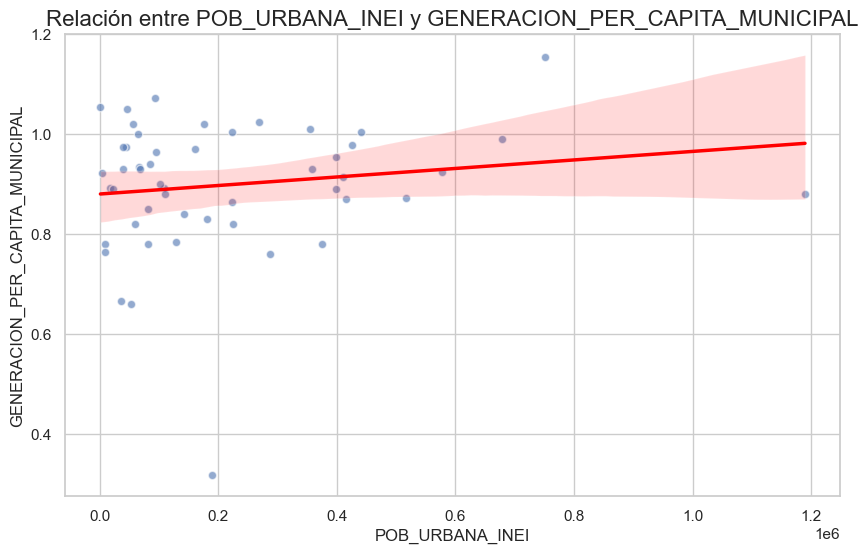

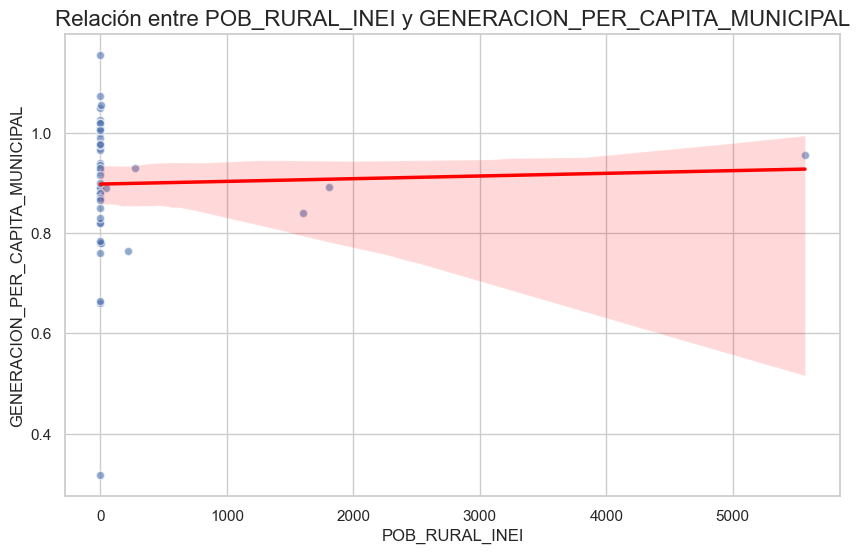

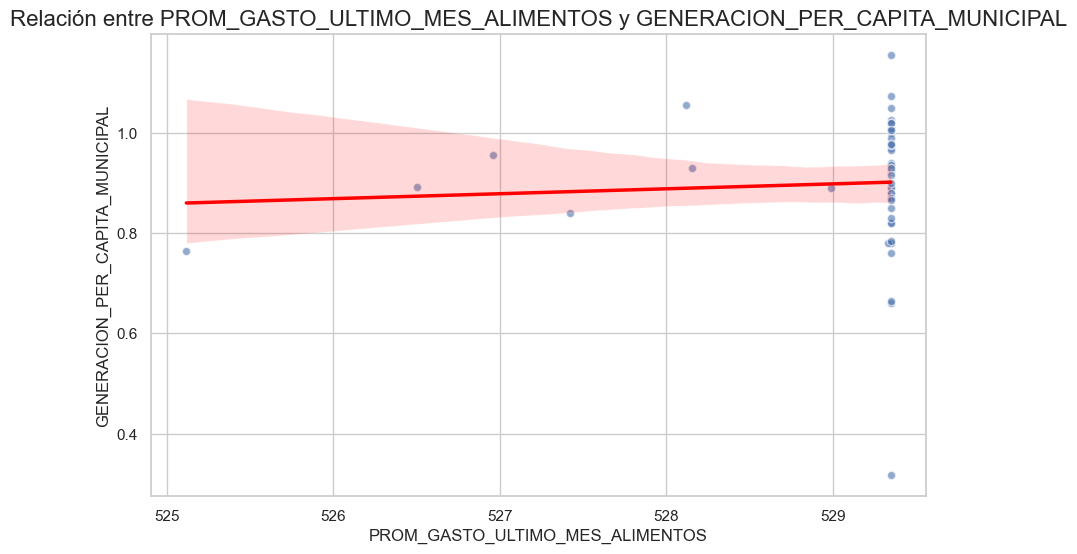

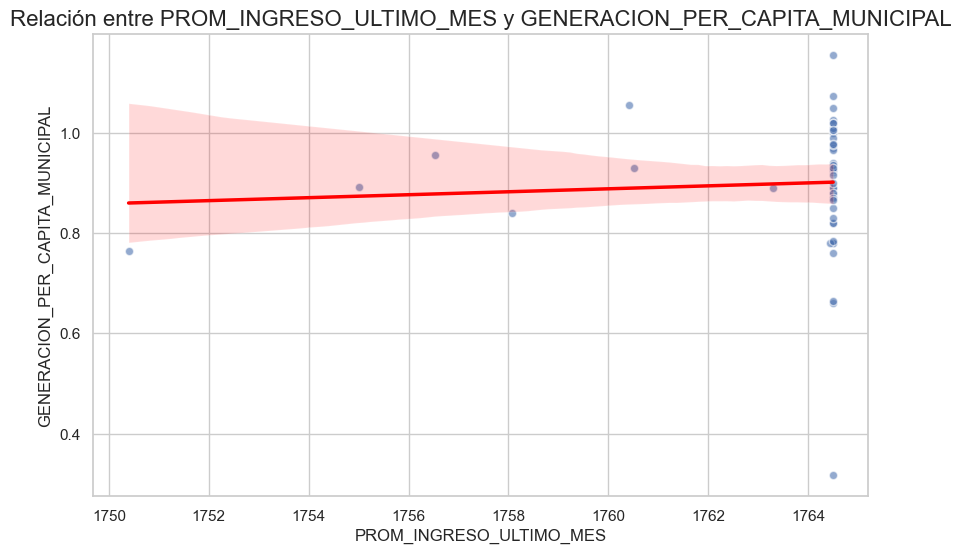

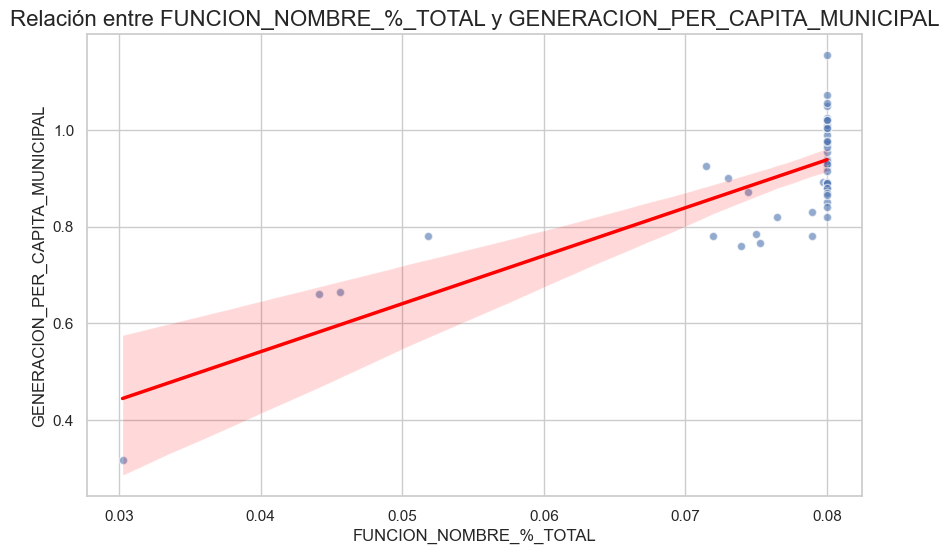

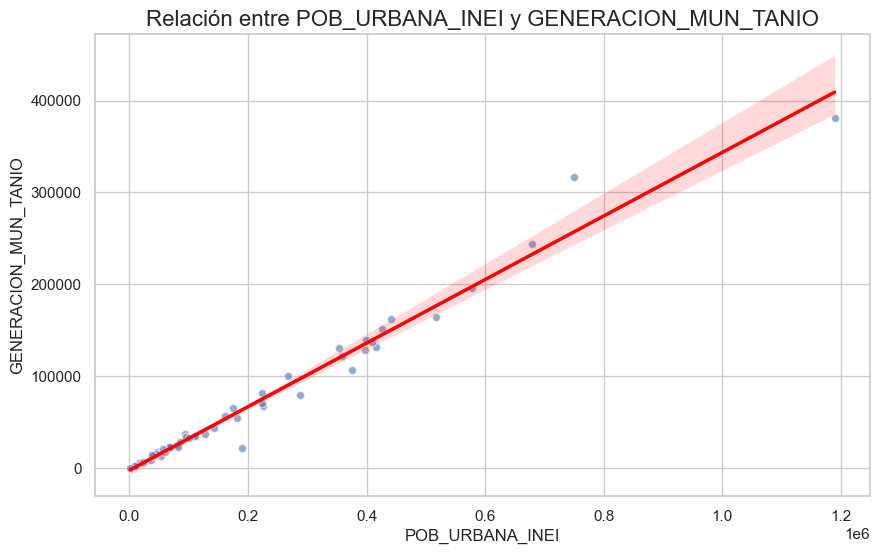

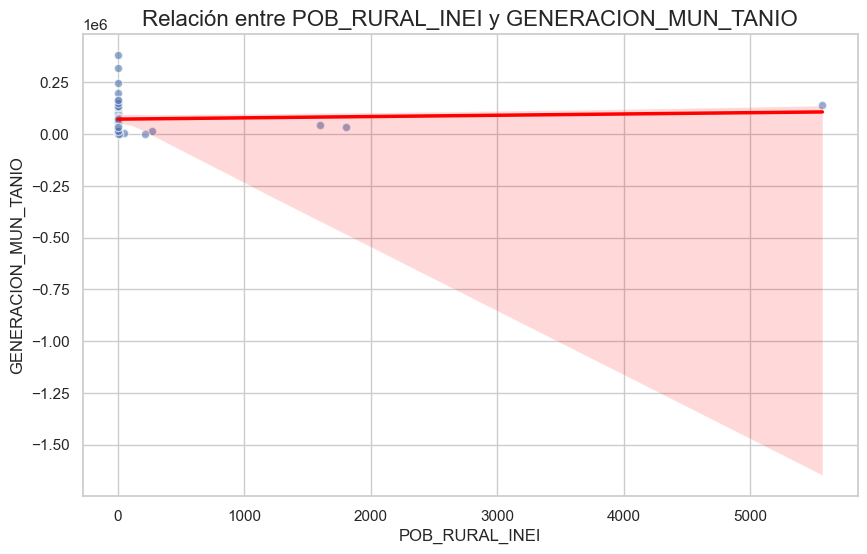

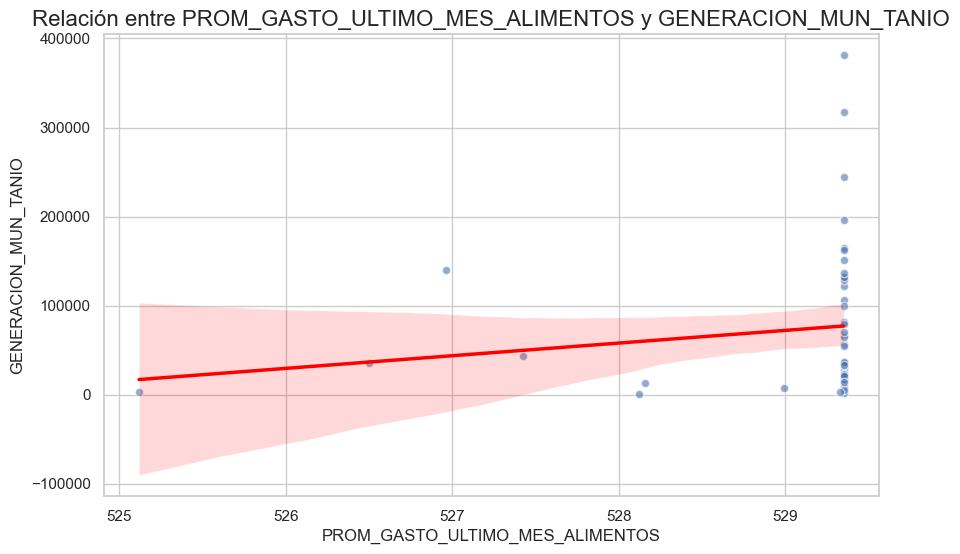

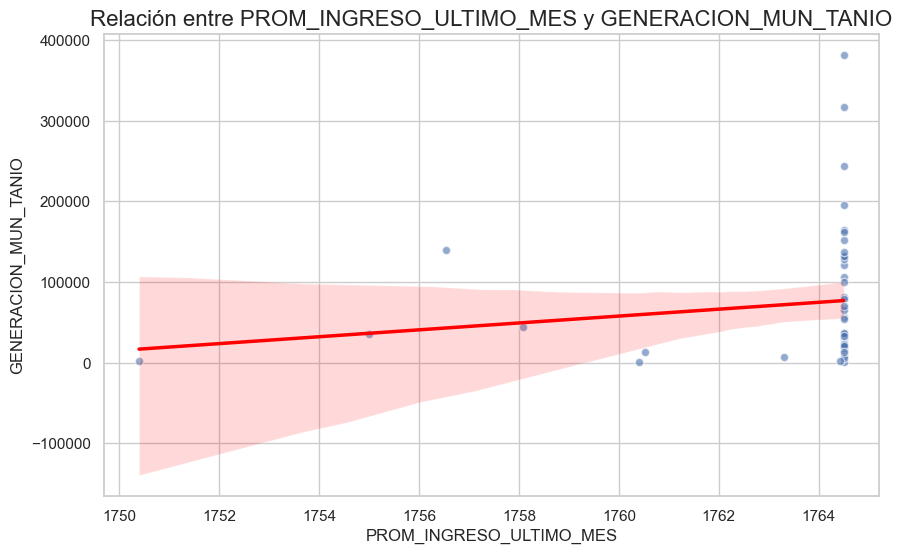

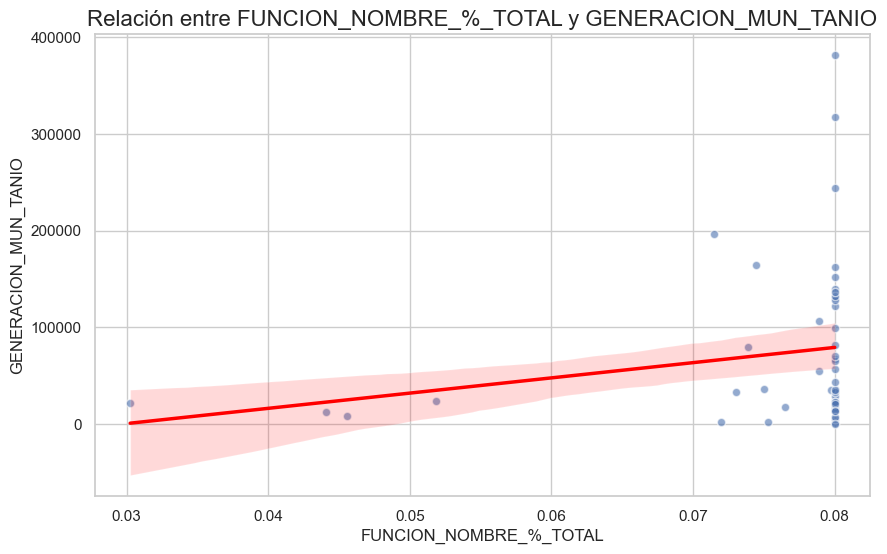

In [94]:
#ANALICEMOS ALGUNOS GRAFICOS QUE REVELAN INFORMACION SOBRE EL ESTADO ACTUAL EN LOS DISTRITOS DE LIMA Y CALLAO
#TODAS LAS VARIABLES VS GENERACION
for objetivo in variables_objetivo:
    for predictora in variables_predictoras:
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df_lima_callao, x=predictora, y=objetivo,
                    line_kws={"color": "red", "lw": 2.5},
                    scatter_kws={'alpha': 0.6, 'edgecolor': 'w'})
        plt.title(f'Relación entre {predictora} y {objetivo}', fontsize=16)
        plt.xlabel(predictora, fontsize=12)
        plt.ylabel(objetivo, fontsize=12)
        plt.grid(True)
        plt.show()

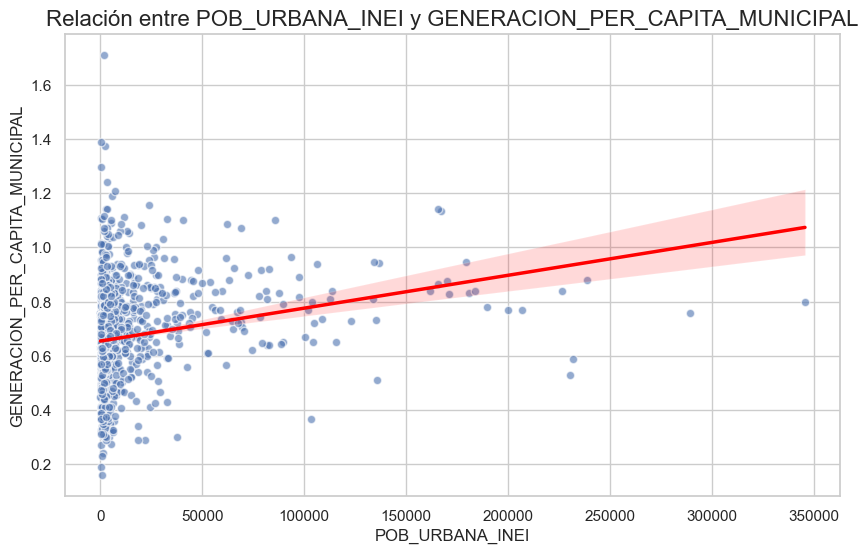

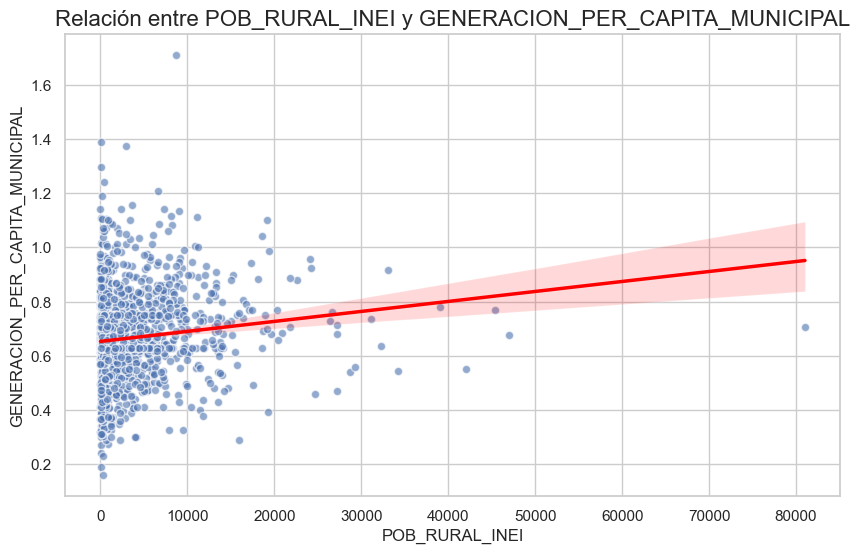

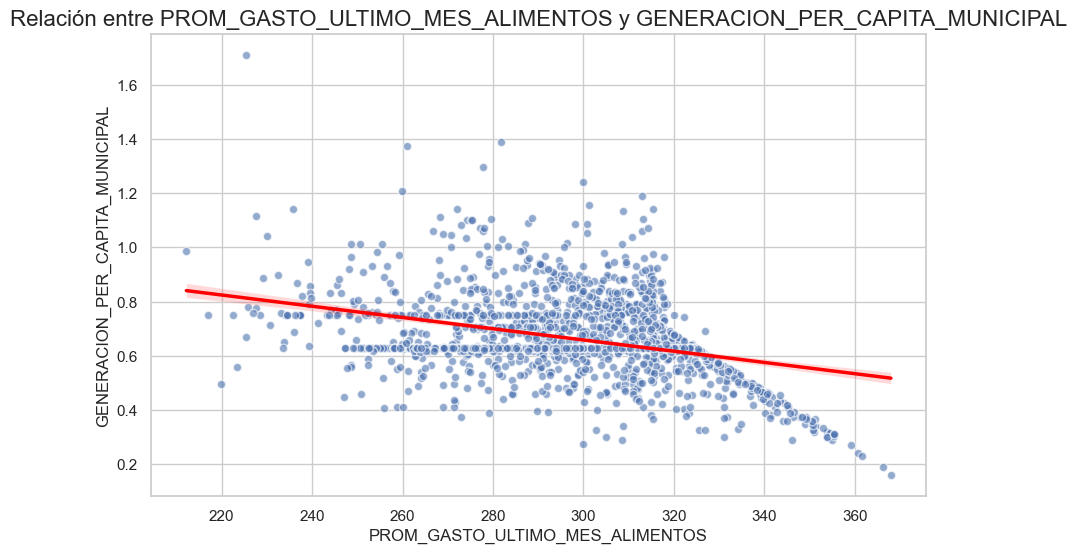

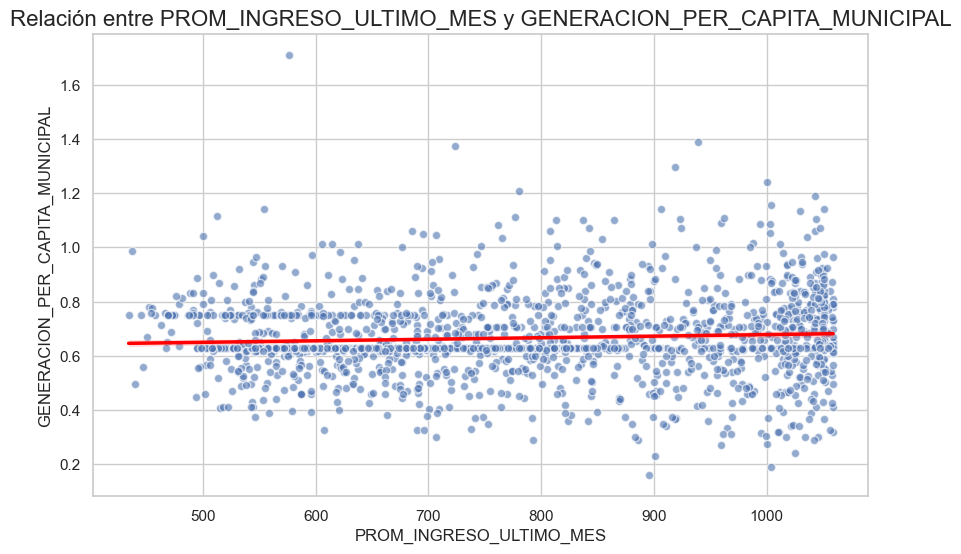

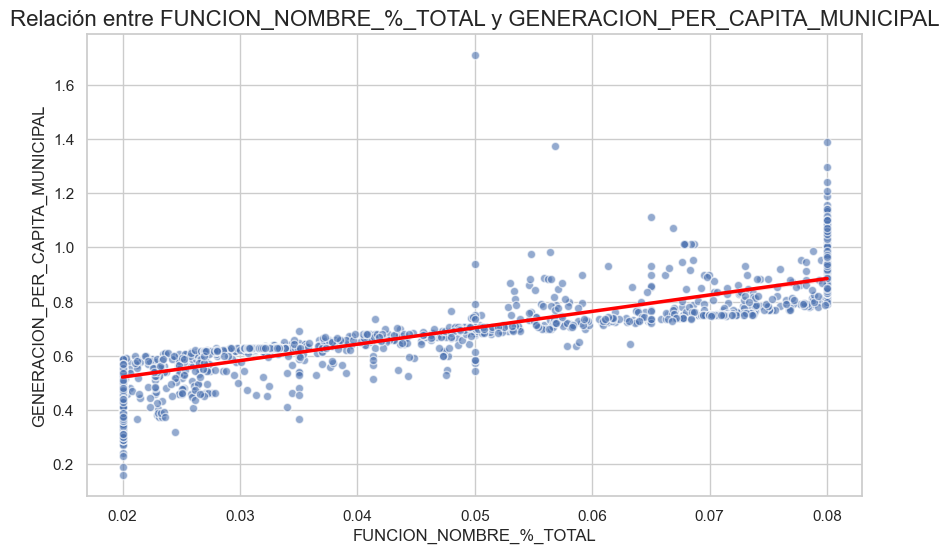

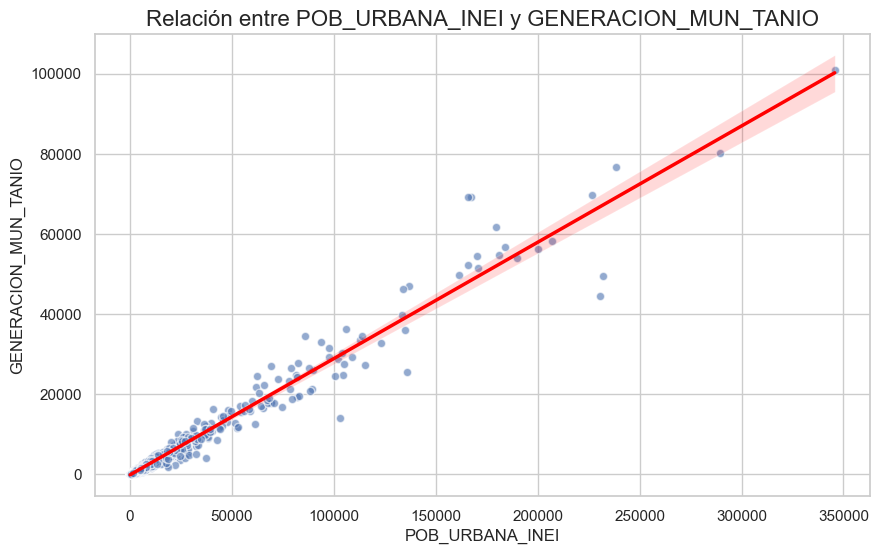

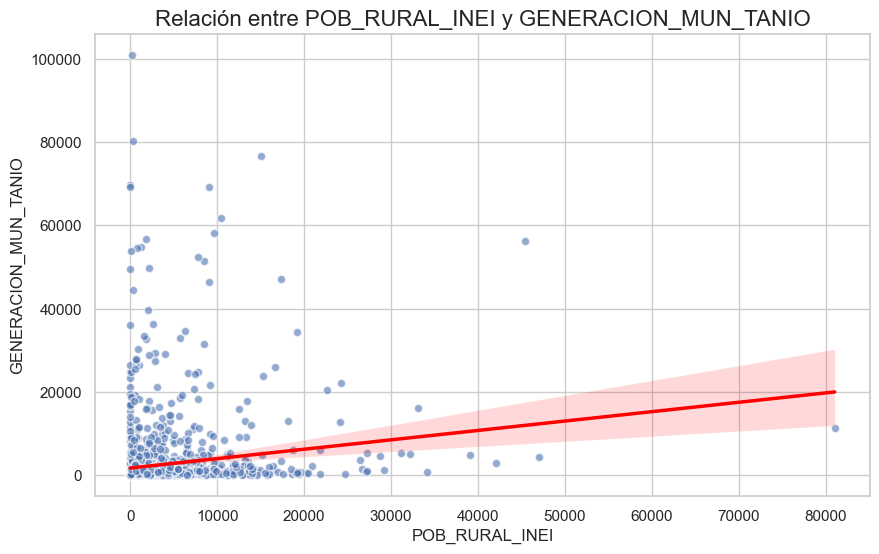

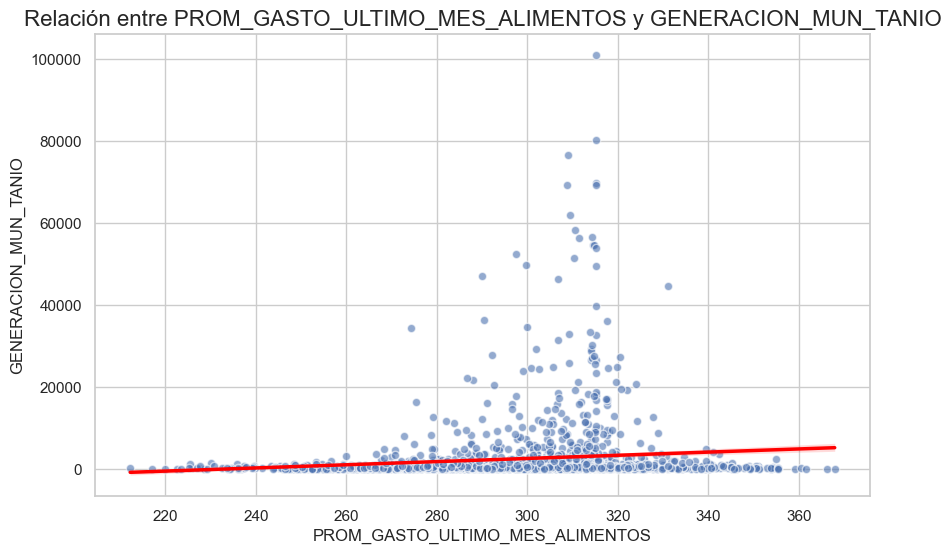

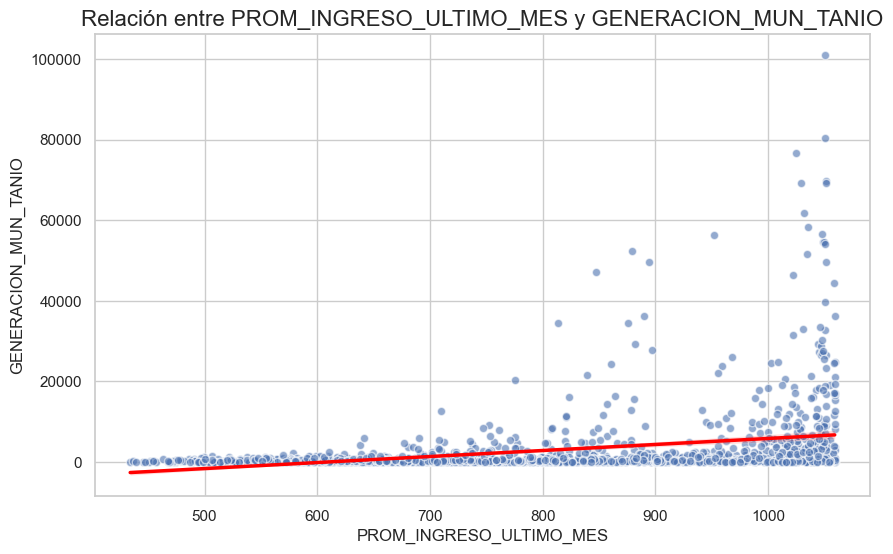

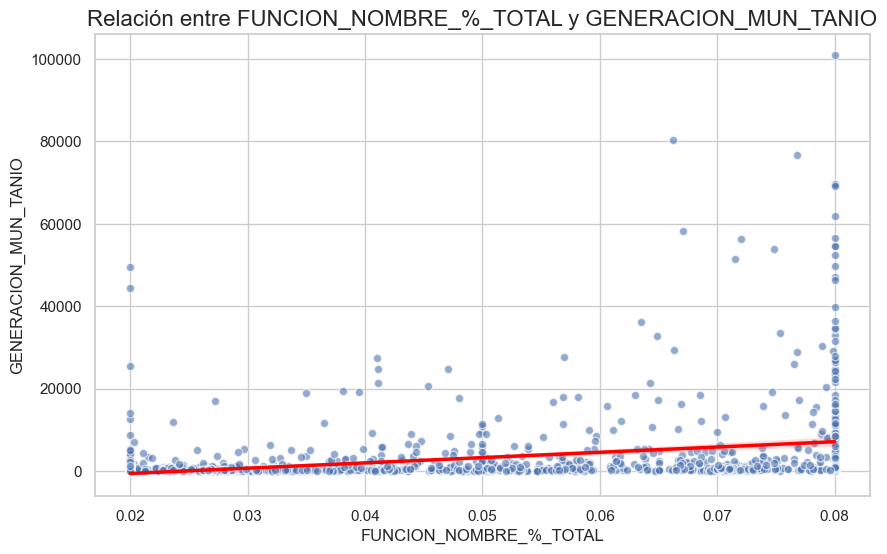

In [95]:
#ANALICEMOS ALGUNOS GRAFICOS QUE REVELAN INFORMACION SOBRE EL ESTADO ACTUAL EN EL RESTO DE DISTRITOS DEL PERU
#TODAS LAS VARIABLES VS GENERACION
for objetivo in variables_objetivo:
    for predictora in variables_predictoras:
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df_resto, x=predictora, y=objetivo,
                    line_kws={"color": "red", "lw": 2.5},
                    scatter_kws={'alpha': 0.6, 'edgecolor': 'w'})
        plt.title(f'Relación entre {predictora} y {objetivo}', fontsize=16)
        plt.xlabel(predictora, fontsize=12)
        plt.ylabel(objetivo, fontsize=12)
        plt.grid(True)
        plt.show()

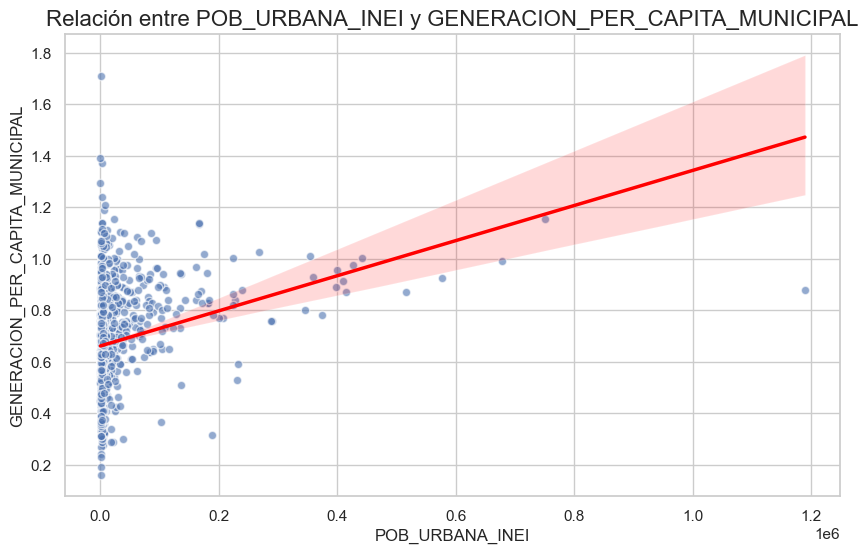

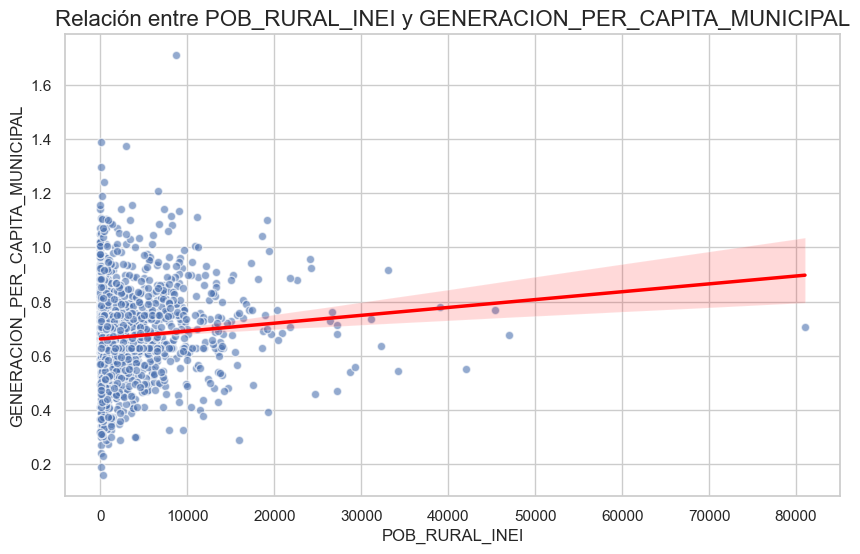

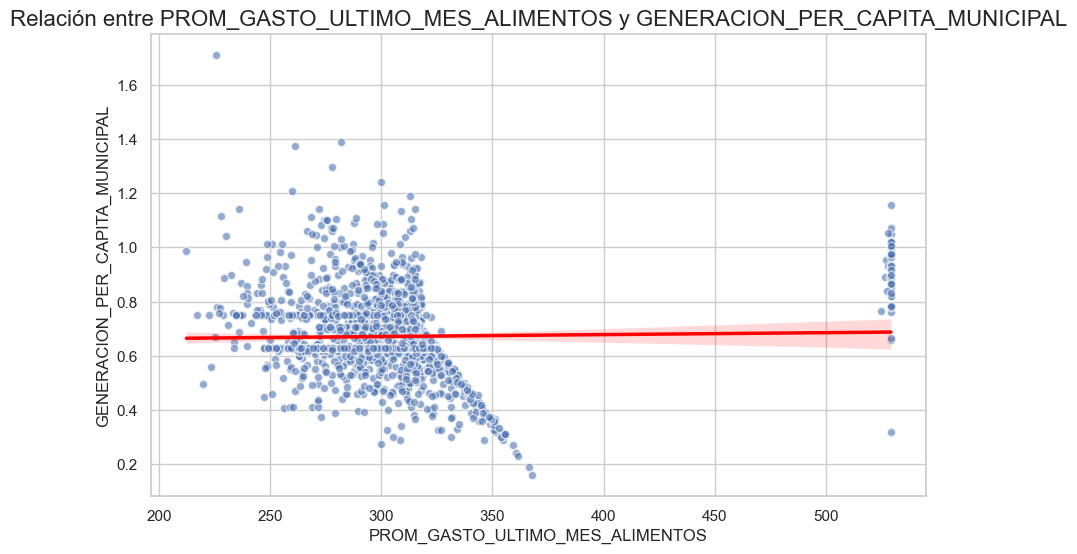

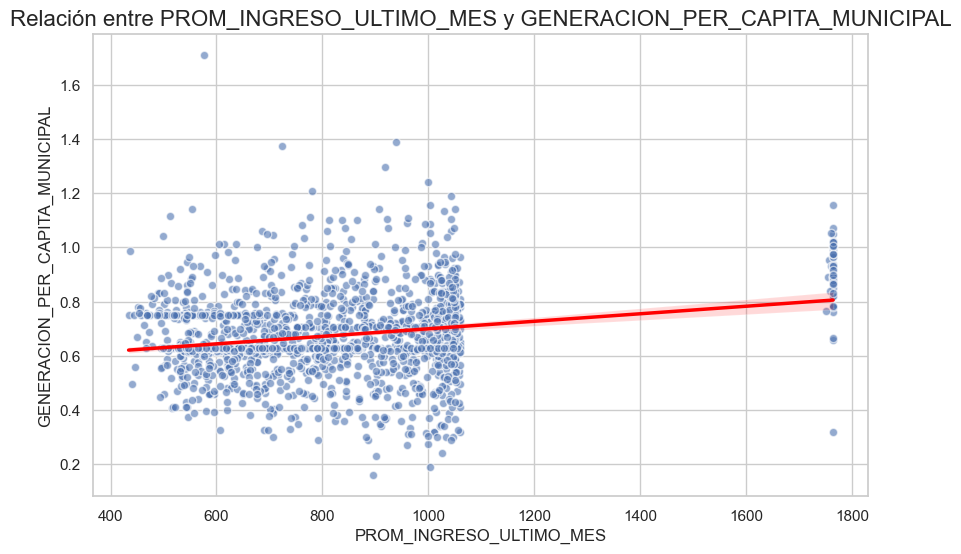

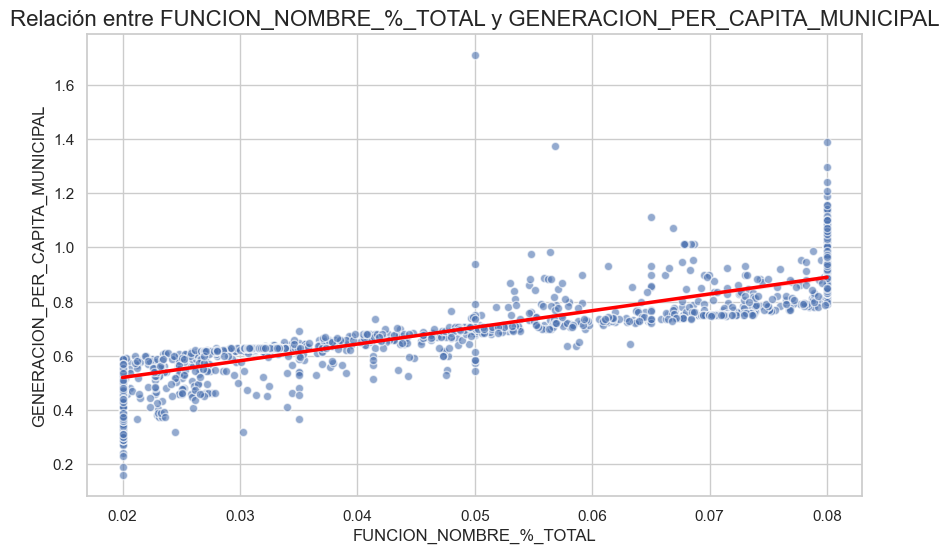

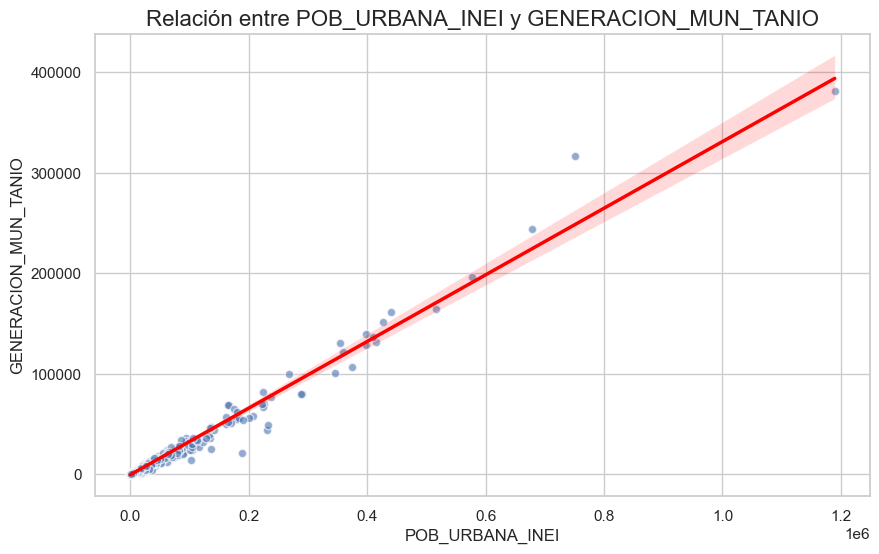

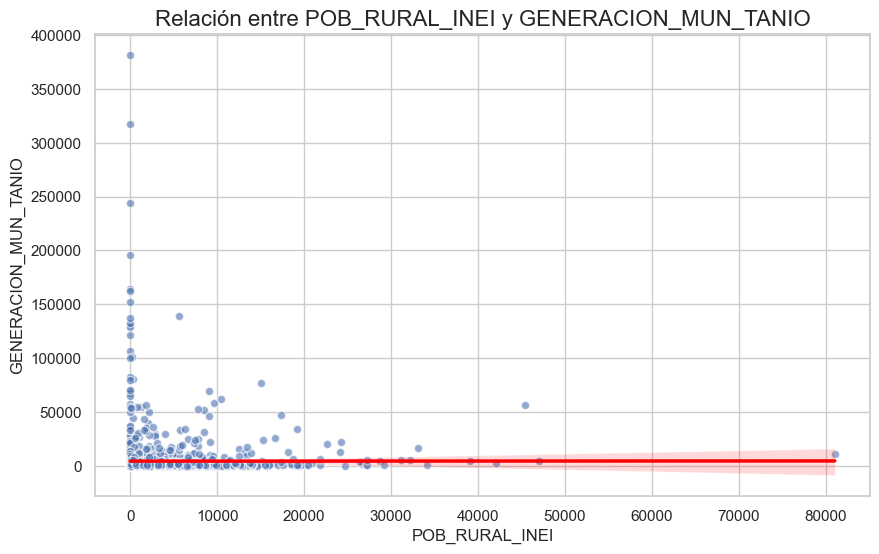

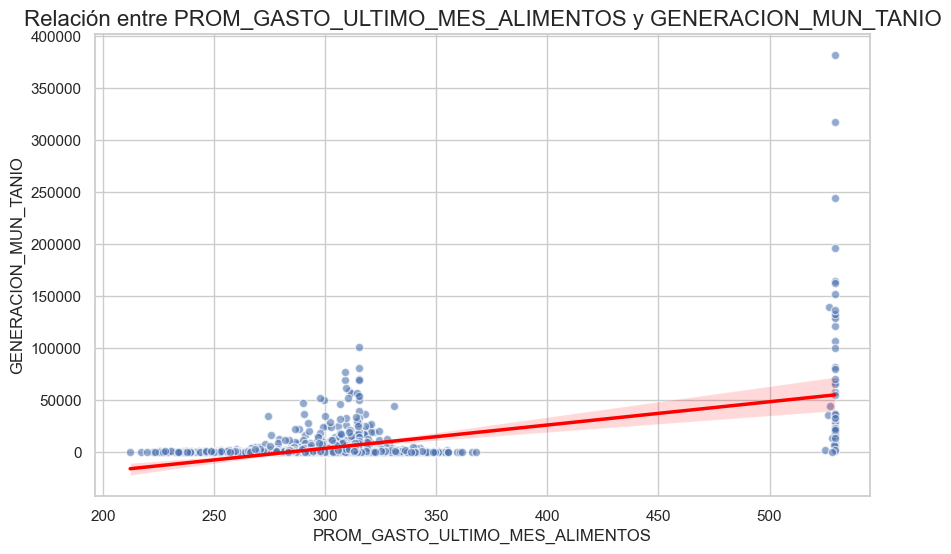

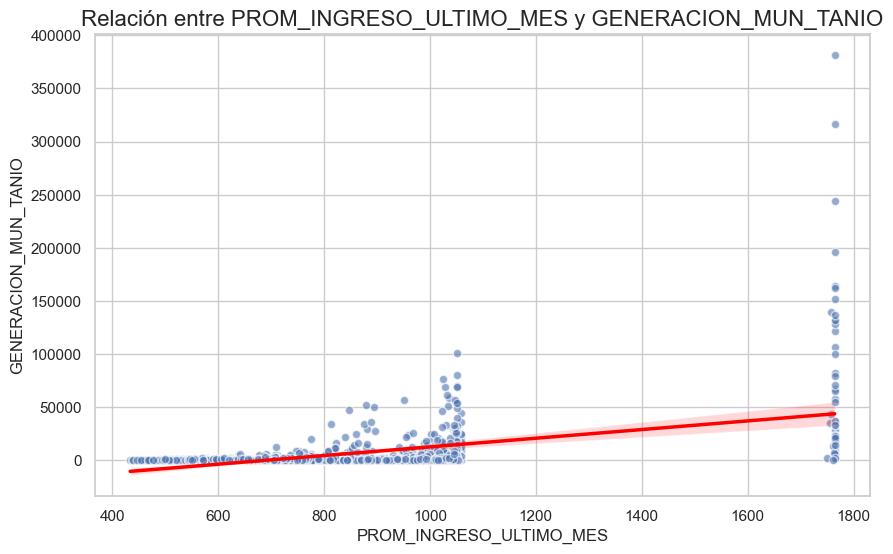

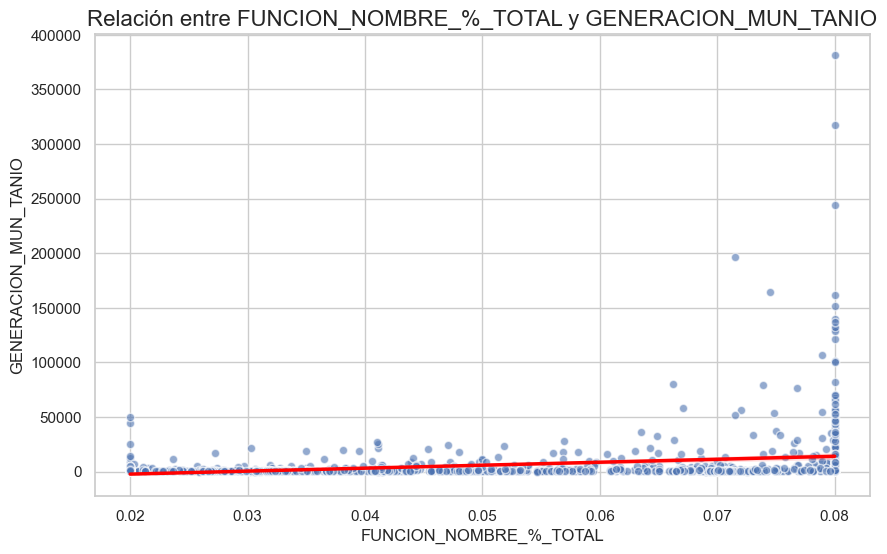

In [96]:
#ANALICEMOS ALGUNOS GRAFICOS QUE REVELAN INFORMACION SOBRE EL ESTADO ACTUAL EN TODO EL CONJUNTO DE DISTRITOS
#TODAS LAS VARIABLES VS GENERACION
for objetivo in variables_objetivo:
    for predictora in variables_predictoras:
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df_agg, x=predictora, y=objetivo,
                    line_kws={"color": "red", "lw": 2.5},
                    scatter_kws={'alpha': 0.6, 'edgecolor': 'w'})
        plt.title(f'Relación entre {predictora} y {objetivo}', fontsize=16)
        plt.xlabel(predictora, fontsize=12)
        plt.ylabel(objetivo, fontsize=12)
        plt.grid(True)
        plt.show()

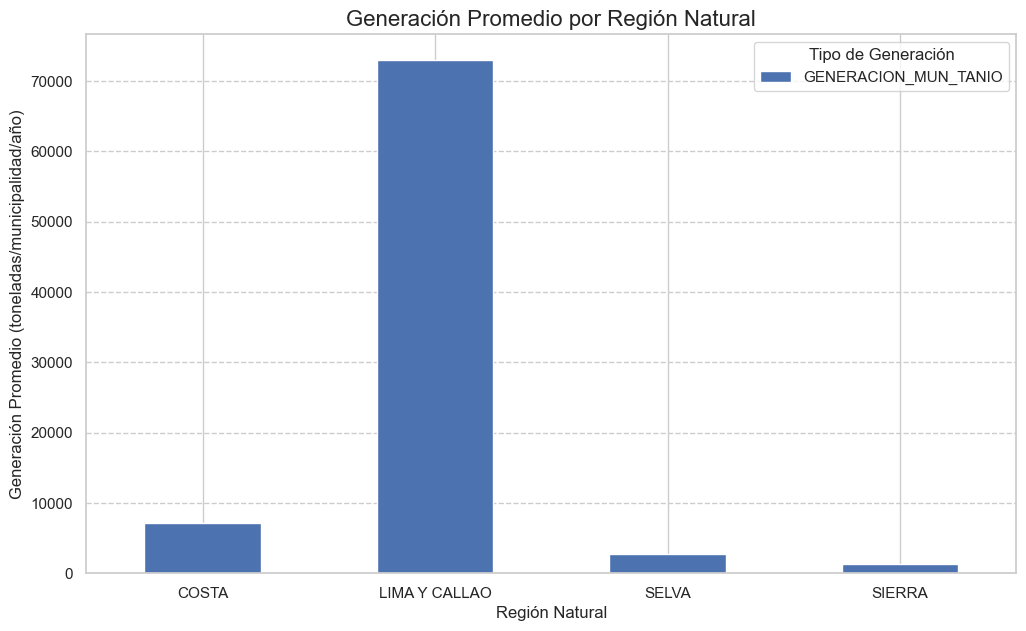

In [97]:
##Generación promedio por Región Natural
plt.figure(figsize=(12, 7))
df_agg.groupby('REGION_NATURAL')['GENERACION_MUN_TANIO'].mean().plot(kind='bar', figsize=(12,7))
plt.title('Generación Promedio por Región Natural', fontsize=16)
plt.ylabel('Generación Promedio (toneladas/municipalidad/año)')
plt.xlabel('Región Natural')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Tipo de Generación')
plt.show()



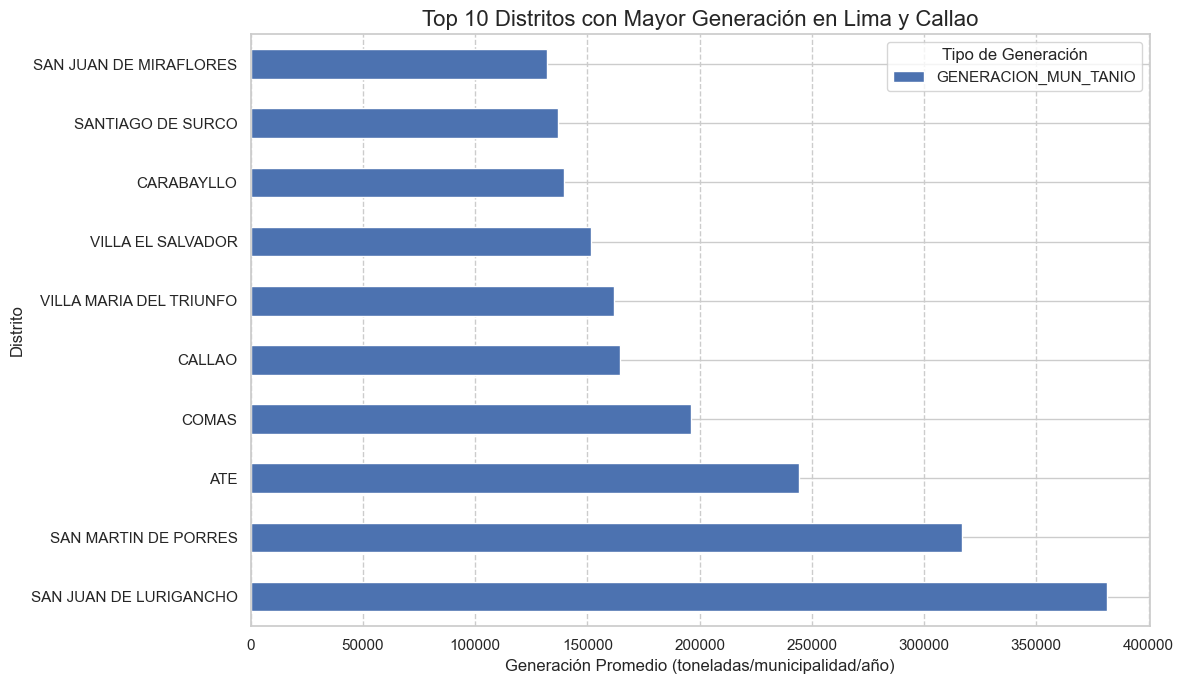

In [98]:
plt.figure(figsize=(12, 7))
# Ordenar y tomar los 10 distritos con mayor generación
top_10_distritos = df_lima_callao.groupby('DISTRITO')['GENERACION_MUN_TANIO'].mean().nlargest(10)

top_10_distritos.plot(kind='barh', figsize=(12,7))
plt.title('Top 10 Distritos con Mayor Generación en Lima y Callao', fontsize=16)
plt.xlabel('Generación Promedio (toneladas/municipalidad/año)')
plt.ylabel('Distrito')
plt.grid(axis='x', linestyle='--')
plt.legend(title='Tipo de Generación')
plt.tight_layout()
plt.show()


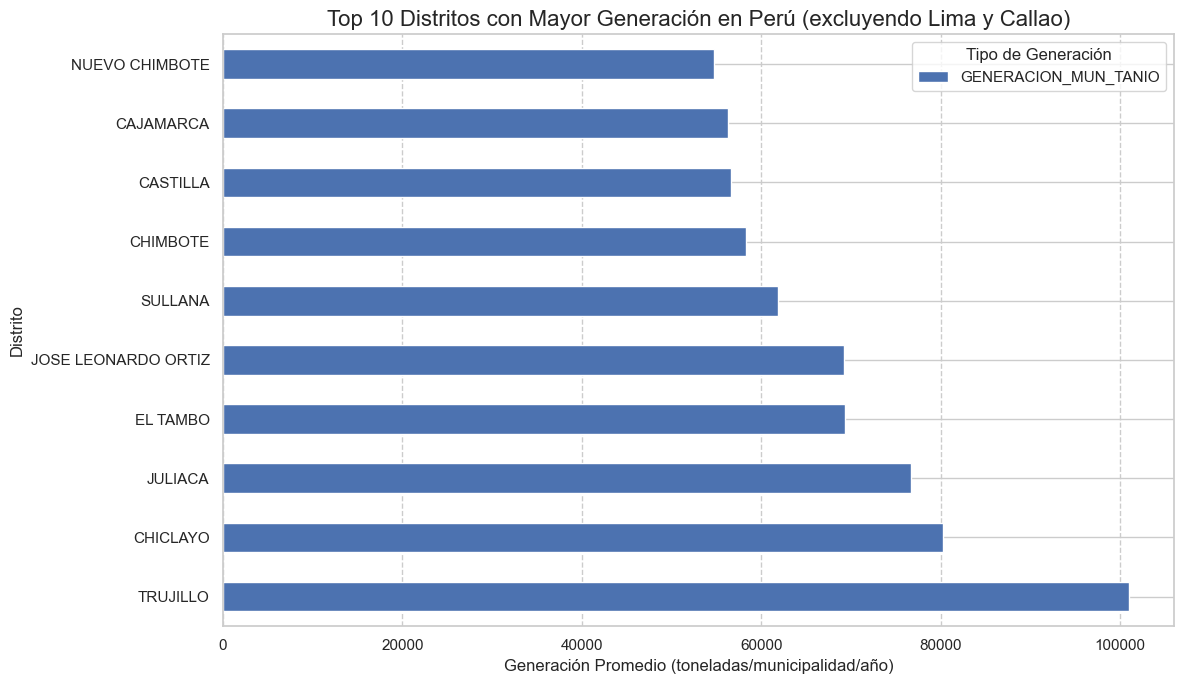

In [145]:
plt.figure(figsize=(12, 7))
# Ordenar y tomar los 10 distritos con mayor generación
top_10_distritos = df_resto.groupby('DISTRITO')['GENERACION_MUN_TANIO'].mean().nlargest(10)

top_10_distritos.plot(kind='barh', figsize=(12,7))
plt.title('Top 10 Distritos con Mayor Generación en Perú (excluyendo Lima y Callao)', fontsize=16)
plt.xlabel('Generación Promedio (toneladas/municipalidad/año)')
plt.ylabel('Distrito')
plt.grid(axis='x', linestyle='--')
plt.legend(title='Tipo de Generación')
plt.tight_layout()
plt.show()

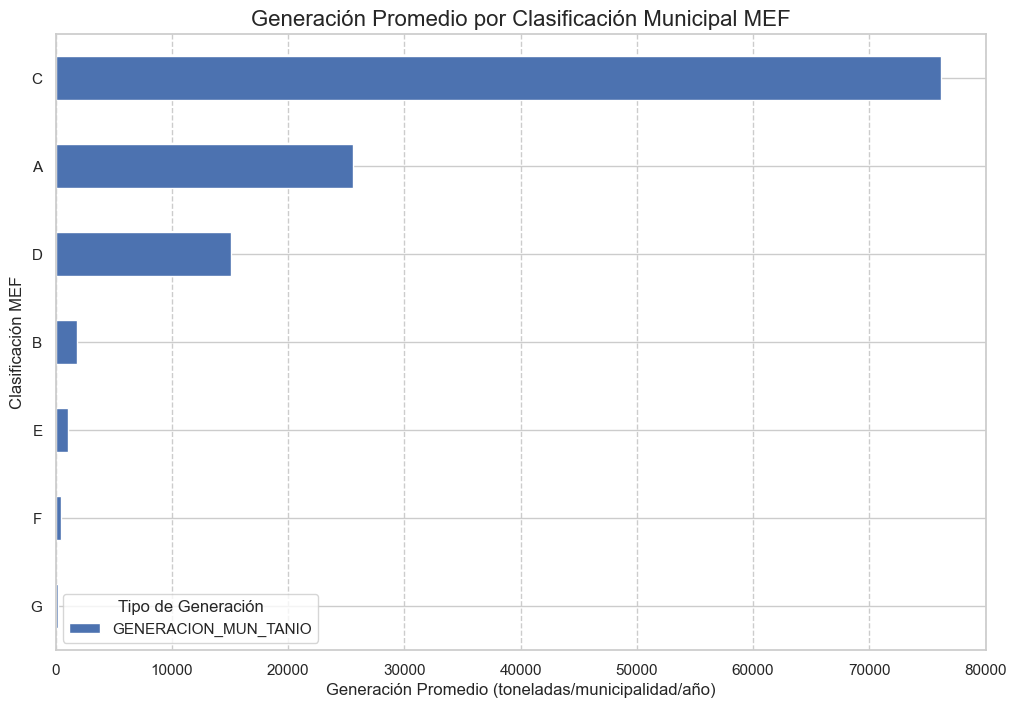

In [100]:
#Generación promedio por Clasificación Municipal MEF
plt.figure(figsize=(12, 7))
df_agg.groupby('CLASIFICACION_MUNICIPAL_MEF')['GENERACION_MUN_TANIO'].mean().sort_values(ascending=True).plot(kind='barh', figsize=(12,8))
plt.title('Generación Promedio por Clasificación Municipal MEF', fontsize=16)
plt.xlabel('Generación Promedio (toneladas/municipalidad/año)')
plt.ylabel('Clasificación MEF')
plt.grid(axis='x', linestyle='--')
plt.legend(title='Tipo de Generación')
plt.show()


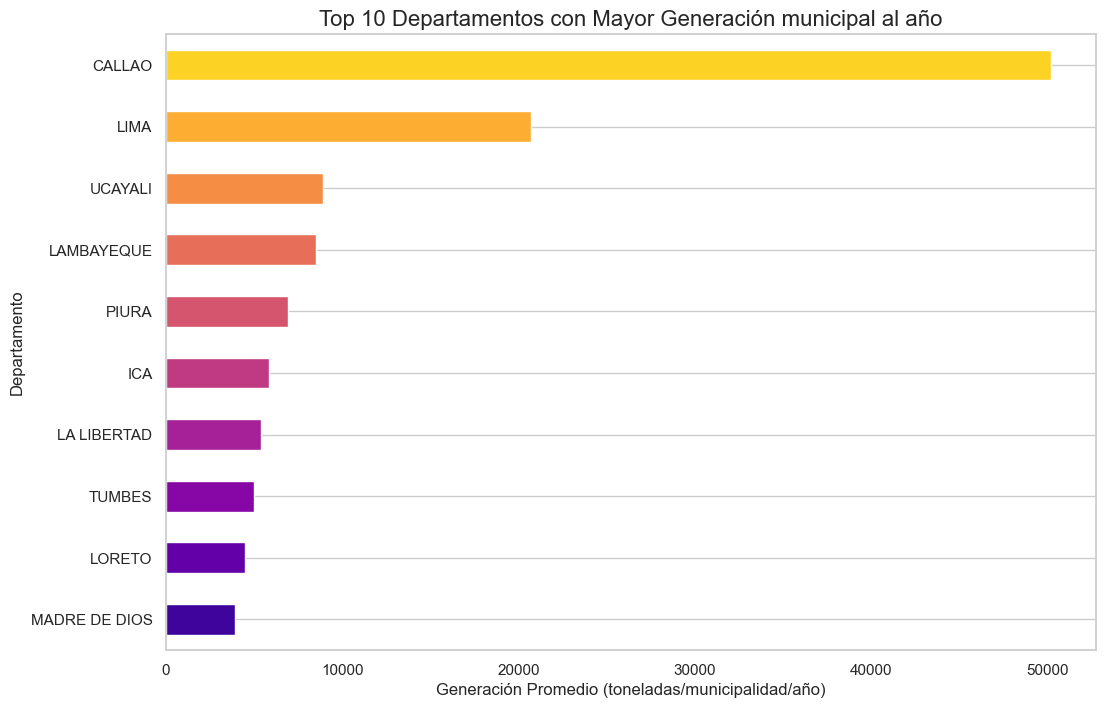

In [101]:
#Top 10 Departamentos con Mayor Generación Municipal
plt.figure(figsize=(12, 8))
top_10_deptos = df_agg.groupby('DEPARTAMENTO')['GENERACION_MUN_TANIO'].mean().nlargest(10).sort_values()
top_10_deptos.plot(kind='barh', color=sns.color_palette('plasma', n_colors=10))
plt.title('Top 10 Departamentos con Mayor Generación municipal al año', fontsize=16)
plt.xlabel('Generación Promedio (toneladas/municipalidad/año)')
plt.ylabel('Departamento')
plt.grid(axis='x')
plt.show()

In [102]:
#############¿QUÉ OCURRE EN EL CALLAO?####################
df_callao = df_lima_callao[df_lima_callao['DEPARTAMENTO'] == 'CALLAO']

In [103]:
df_callao

UBIGEO  POB_URBANA_INEI  POB_RURAL_INEI  GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL DEPARTAMENTO PROVINCIA                    DISTRITO REGION_NATURAL CLASIFICACION_MUNICIPAL_MEF    latitud   longitud  POB_TOTAL_INEI
689   70101        516183.50             0.0                           0.8725           164482.3575                           529.35                   1764.5                0.074449       CALLAO    CALLAO                      CALLAO  LIMA Y CALLAO                           A -12.016752 -77.121133       516183.50
690   70102         80848.25             0.0                           0.8500            25077.6050                           529.35                   1764.5                0.080000       CALLAO    CALLAO                  BELLAVISTA  LIMA Y CALLAO                           D -12.060006 -77.109903        80848.25
691   70103         46553.75             0.0                           1.0500            17854.1900                           529.35                   1764.5                0.080000       CALLAO    CALLAO  CARMEN DE LA LEGUA REYNOSO  LIMA Y CALLAO                           D -12.042885 -77.090418        46553.75
692   70104         64433.00             0.0                           1.0000            23525.0825                           529.35                   1764.5                0.080000       CALLAO    CALLAO                    LA PERLA  LIMA Y CALLAO                           D -12.070277 -77.116098        64433.00
693   70105          3915.50             0.0                           0.9225             1322.4250                           529.35                   1764.5                0.080000       CALLAO    CALLAO                    LA PUNTA  LIMA Y CALLAO                           D -12.071695 -77.162783         3915.50
694   70106        374777.75             0.0                           0.7800           106473.9500                           529.35                   1764.5                0.078917       CALLAO    CALLAO                  VENTANILLA  LIMA Y CALLAO                           D -11.879125 -77.130864       374777.75
695   70107         52911.75             0.0                           0.6600            12691.2600                           529.35                   1764.5                0.044108       CALLAO    CALLAO                     MI PERU  LIMA Y CALLAO                           D -11.854339 -77.120556        52911.75

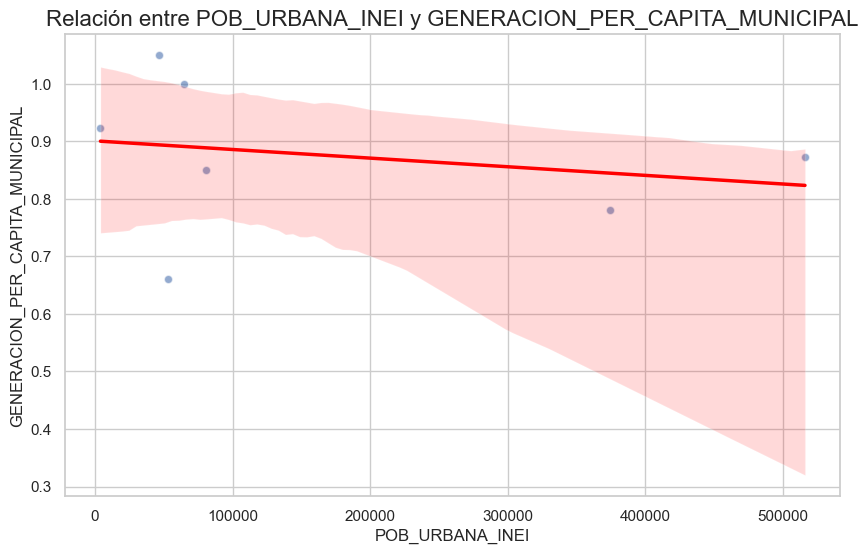

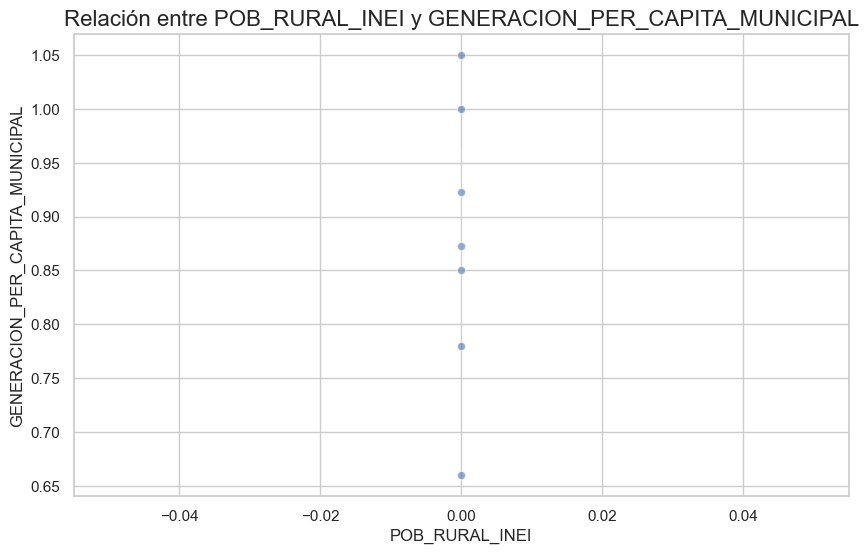

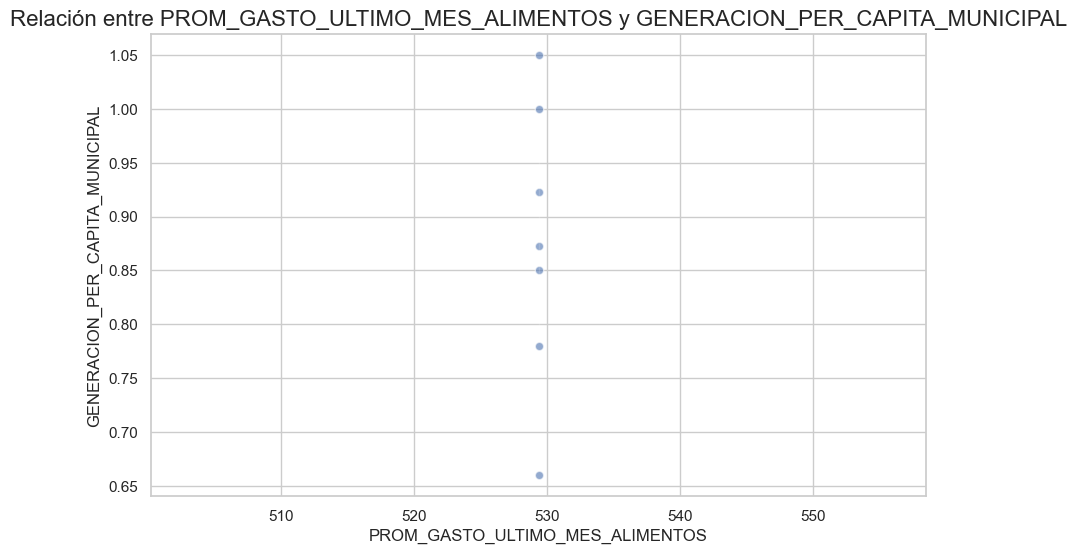

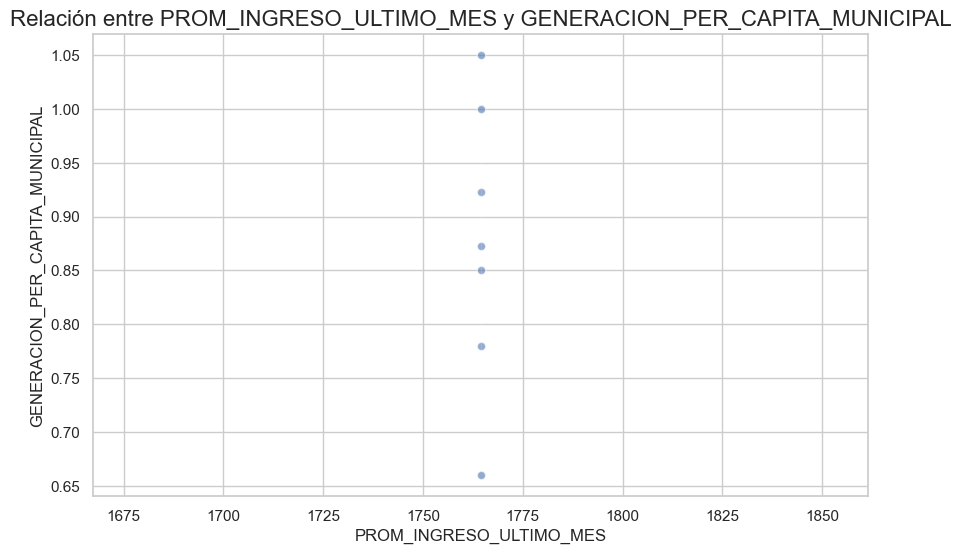

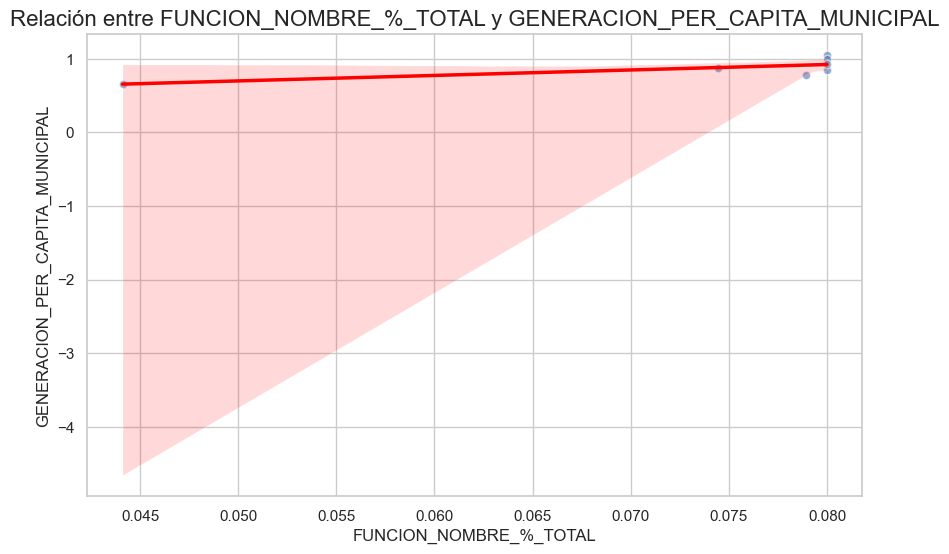

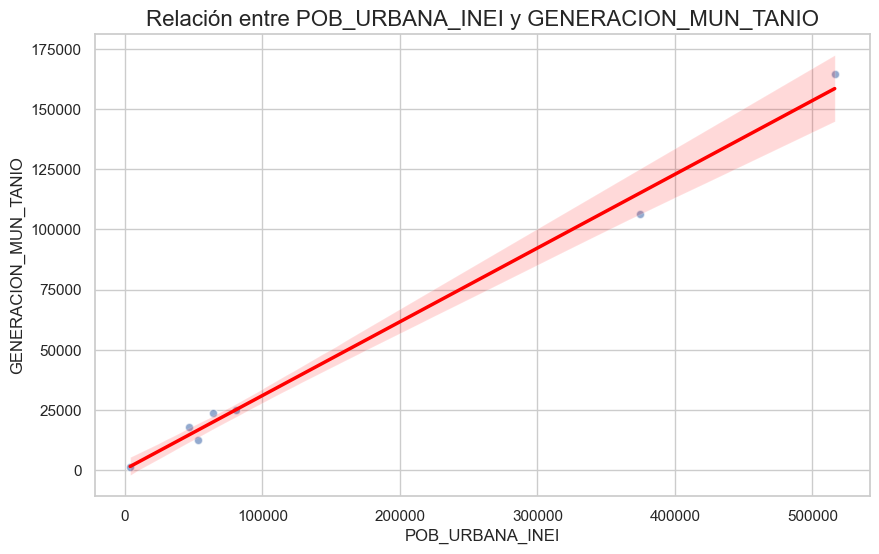

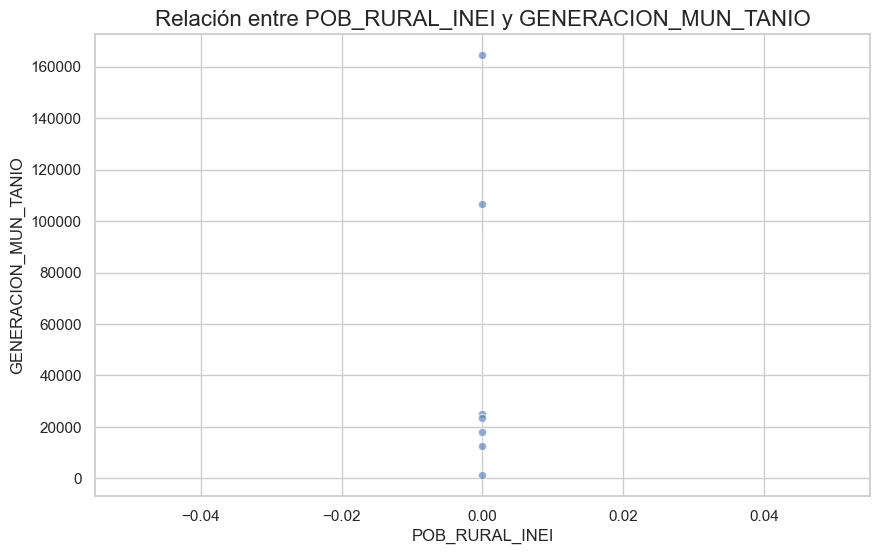

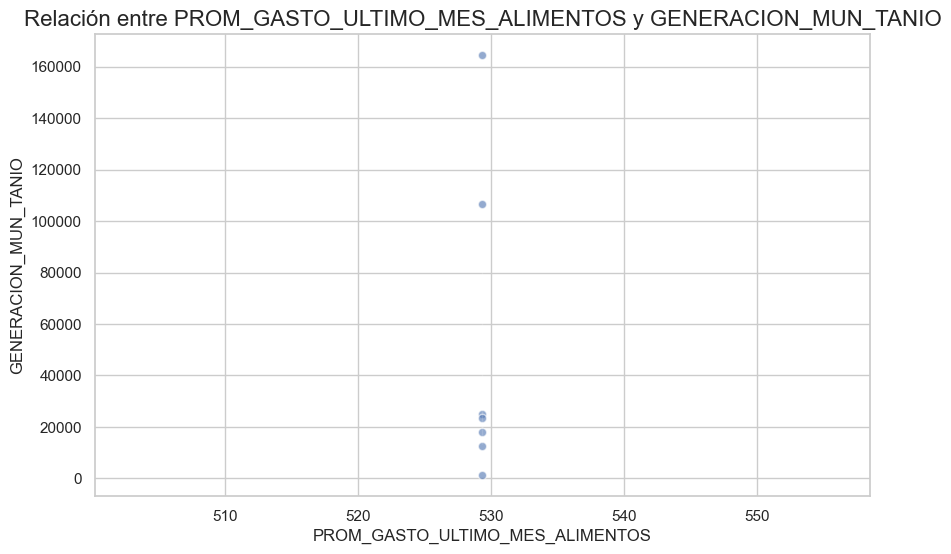

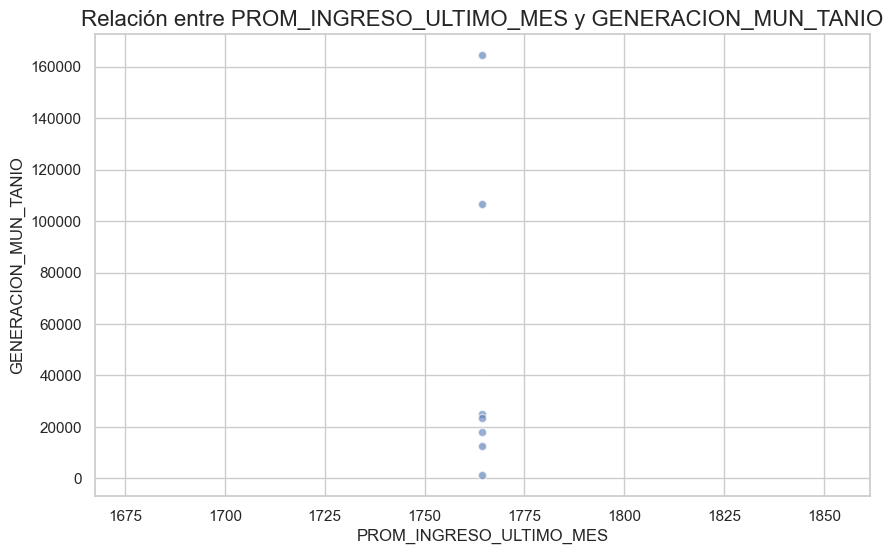

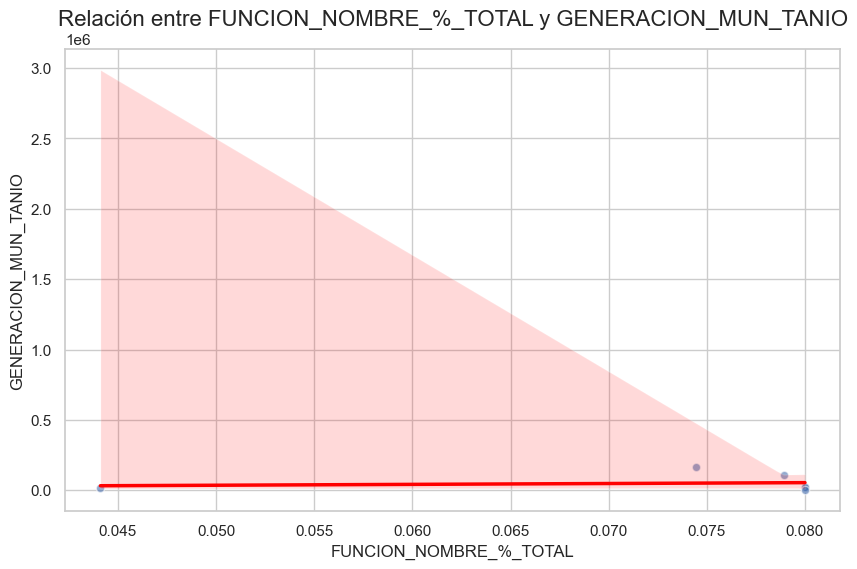

In [104]:
#TODAS LAS VARIABLES VS GENERACION SOLO EN LOS DISTRITOS DEL CALLAO
for objetivo in variables_objetivo:
    for predictora in variables_predictoras:
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df_callao, x=predictora, y=objetivo,
                    line_kws={"color": "red", "lw": 2.5},
                    scatter_kws={'alpha': 0.6, 'edgecolor': 'w'})
        plt.title(f'Relación entre {predictora} y {objetivo}', fontsize=16)
        plt.xlabel(predictora, fontsize=12)
        plt.ylabel(objetivo, fontsize=12)
        plt.grid(True)
        plt.show()

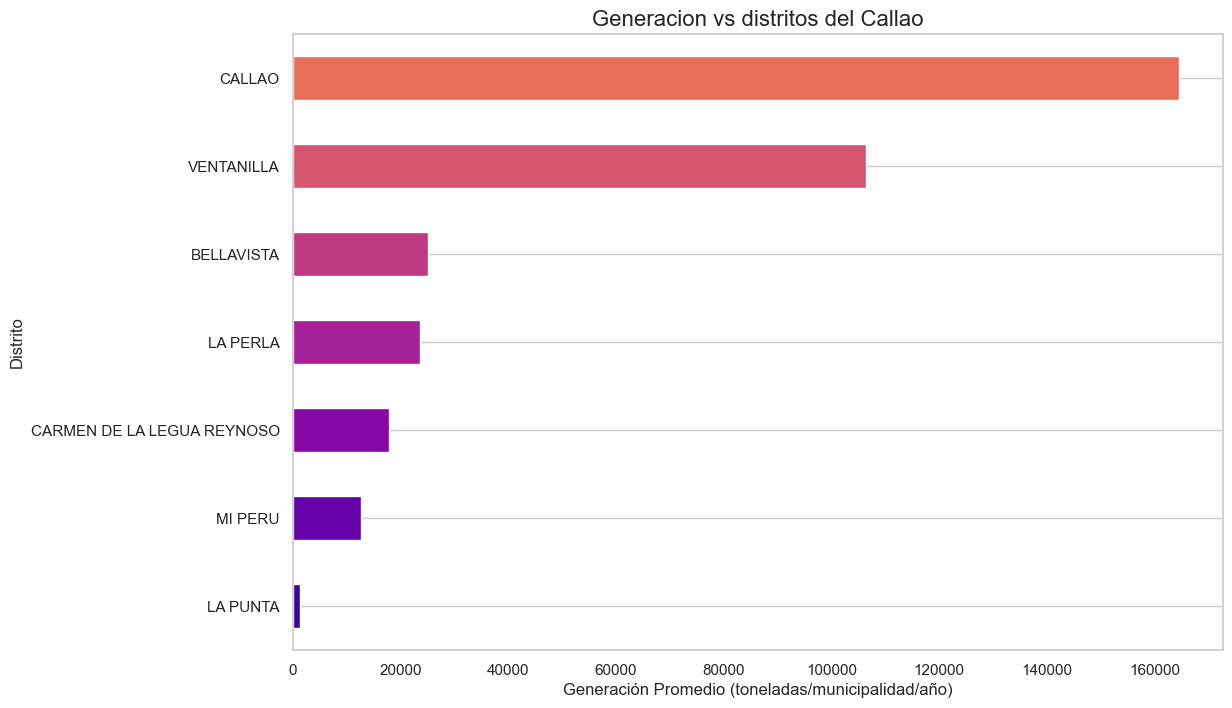

In [105]:
#Distritos del callaro vs generación 
plt.figure(figsize=(12, 8))
distritos = df_callao.groupby('DISTRITO')['GENERACION_MUN_TANIO'].mean().nlargest(10).sort_values()
distritos.plot(kind='barh', color=sns.color_palette('plasma', n_colors=10))
plt.title('Generacion vs distritos del Callao', fontsize=16)
plt.xlabel('Generación Promedio (toneladas/municipalidad/año)')
plt.ylabel('Distrito')
plt.grid(axis='x')
plt.show()

# **CLUSTERING CON K-MEANS**

In [114]:
#PREPROCESAMIENTO DE DATOS PARA CLUSTERING
#Definir variables numéricas y categóricas para el modelo ---
numeric_features = [
     'GENERACION_PER_CAPITA_MUNICIPAL',
    'GENERACION_MUN_TANIO', 'PROM_GASTO_ULTIMO_MES_ALIMENTOS',
    'PROM_INGRESO_ULTIMO_MES', 'FUNCION_NOMBRE_%_TOTAL'
]
categorical_features = ['REGION_NATURAL', 'CLASIFICACION_MUNICIPAL_MEF']

In [115]:
#Crear un pipeline de preprocesamiento robusto con los transformadores 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [116]:
#Aplicar el preprocesamiento
X_processed = preprocessor.fit_transform(df_resto)
print("Datos preprocesados y listos para el clustering. Dimensiones:", X_processed.shape)


Datos preprocesados y listos para el clustering. Dimensiones: (1822, 14)



   INSTRUCCIÓN: Observa el gráfico de abajo. El 'codo' (donde la tasa de
 descenso se ralentiza) indica un buen balance. Ese es tu K óptimo. En nuestro caso es 4, pero esto puede variar


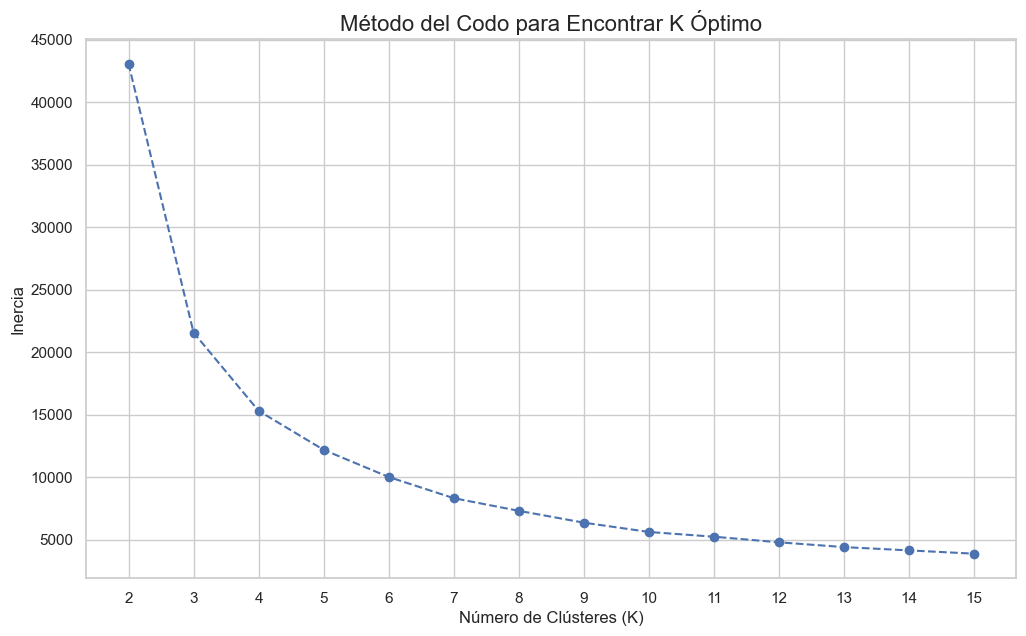


   Número de clústeres seleccionado: K = 3


In [124]:
#ENCONTRAR EL NÚMERO ÓPTIMO DE CLÚSTERES (K) CON EL MÉTODO DEL CODO

#Calculamos la inercia (suma de las distancias al cuadrado) para un rango de K
inertia = []
k_range = range(2, 16) # Probaremos de 2 a 15 clústeres

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Graficamos los resultados
plt.figure(figsize=(12, 7))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Método del Codo para Encontrar K Óptimo', fontsize=16)
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
print("\n   INSTRUCCIÓN: Observa el gráfico de abajo. El 'codo' (donde la tasa de")
print(" descenso se ralentiza) indica un buen balance. Ese es tu K óptimo. En nuestro caso es 3, pero esto puede variar")
plt.show() #Definición del K óptimo
# NOTA IMPORTANTE: Si estas usando nuestro modelo debes ajustar 'optimal_k' basándote en el "codo" del gráfico anterior.
# Por ejemplo, si el codo está en 4, cambia el valor a 4 o si deseas probar menos, puedes poner 3.
optimal_k = 3 # <--- ¡¡AJUSTA ESTE VALOR BASADO EN TU GRÁFICO!!
print(f"\n   Número de clústeres seleccionado: K = {optimal_k}")


K = 2: Silhouette Score = 0.8901
K = 3: Silhouette Score = 0.8213
K = 4: Silhouette Score = 0.6630
K = 5: Silhouette Score = 0.6444
K = 6: Silhouette Score = 0.4684
K = 7: Silhouette Score = 0.3340
K = 8: Silhouette Score = 0.3261
K = 9: Silhouette Score = 0.3381
K = 10: Silhouette Score = 0.3381
K = 11: Silhouette Score = 0.3408
K = 12: Silhouette Score = 0.3479
K = 13: Silhouette Score = 0.3440
K = 14: Silhouette Score = 0.3525
K = 15: Silhouette Score = 0.3619


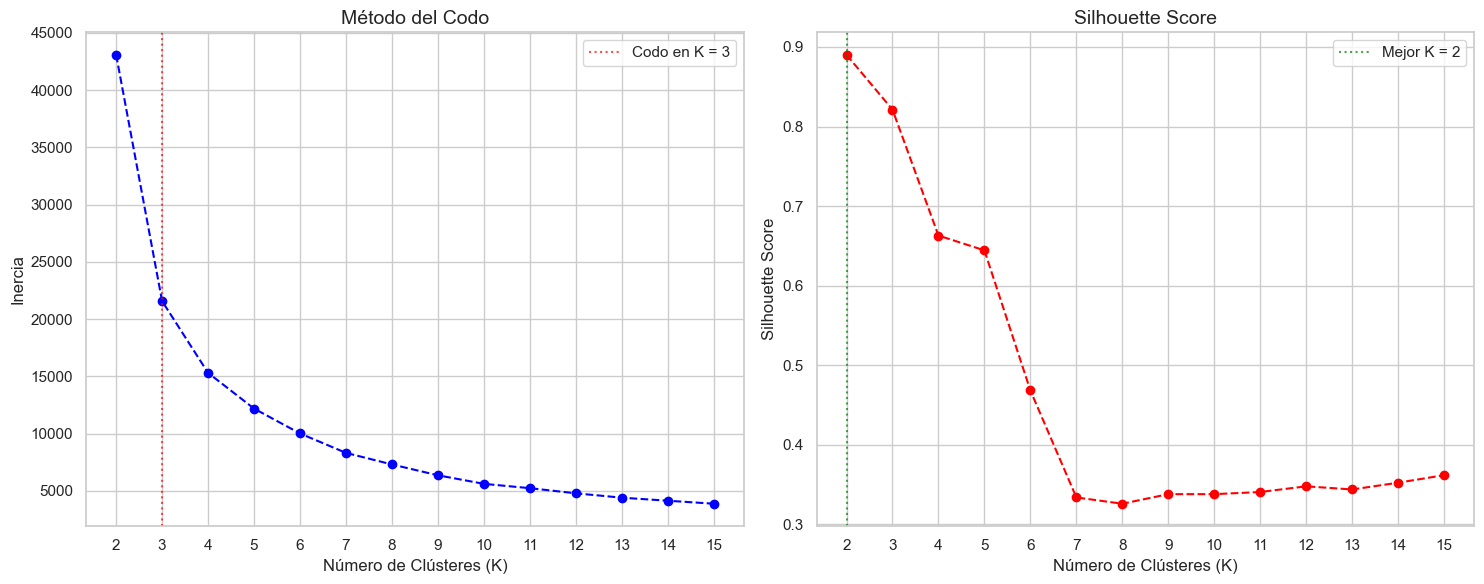

In [125]:
# Gráfico comparativo: Método del Codo vs Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Método del Codo
ax1.plot(k_range, inertia, marker='o', linestyle='--', color='blue')
ax1.set_title('Método del Codo', fontsize=14)
ax1.set_xlabel('Número de Clústeres (K)')
ax1.set_ylabel('Inercia')
ax1.set_xticks(k_range)
ax1.grid(True)
ax1.axvline(x=optimal_k, color='red', linestyle=':', alpha=0.7, 
           label=f'Codo en K = {optimal_k}')
# Calculamos el silhouette score para el mismo rango de K
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)
    
    # Calculamos el silhouette score
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {k}: Silhouette Score = {silhouette_avg:.4f}")
# Resaltamos el mejor score
best_k_index = np.argmax(silhouette_scores)
best_k = k_range[best_k_index]
best_score = silhouette_scores[best_k_index]

# Gráfico 2: Silhouette Score
ax2.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='red')
ax2.set_title('Silhouette Score', fontsize=14)
ax2.set_xlabel('Número de Clústeres (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(k_range)
ax2.grid(True)
ax2.axvline(x=best_k, color='green', linestyle=':', alpha=0.7, 
           label=f'Mejor K = {best_k}')

ax1.legend()
ax2.legend()
plt.tight_layout()

In [126]:
df_original = df_resto

In [127]:
#APLICACIÓN DEL ALGORITMO K-MEANS

print("\nAplicando el algoritmo K-Means con K =", optimal_k)

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_processed)

# Añadir los resultados al DataFrame original
df_original['cluster'] = clusters



Aplicando el algoritmo K-Means con K = 3


In [128]:
#ANÁLISIS Y VISUALIZACIÓN DE LOS CLÚSTERES
#Resumen de los clústeres encontrados ---
print(f"\n   Resumen del Clustering (K={optimal_k}):")
print(df_original['cluster'].value_counts().sort_index())

#Perfilado de Clústeres (Cluster Profiling) ---
print("\n--- Perfil Promedio de Cada Clúster (Valores Medios) ---")
# Usamos median para ser consistentes con la robustez del scaler
cluster_profile = df_original.groupby('cluster')[numeric_features].median().round(2)
print(cluster_profile)


   Resumen del Clustering (K=3):
cluster
0    1720
1      82
2      20
Name: count, dtype: int64

--- Perfil Promedio de Cada Clúster (Valores Medios) ---
         GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL
cluster                                                                                                                                         
0                                   0.63                259.35                           297.86                   735.30                    0.03
1                                   0.79              18131.42                           311.64                  1029.44                    0.08
2                                   0.84              55502.26                           312.83                  1041.31                    0.08


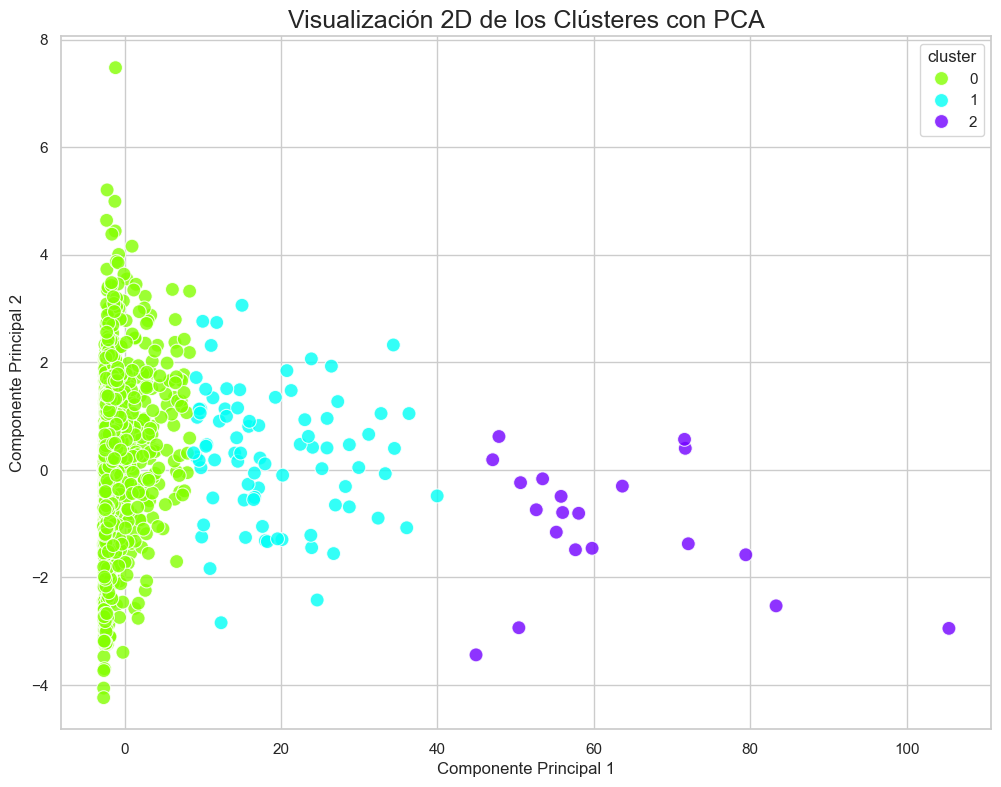

In [129]:
#Visualización de Clústeres con PCA (Reducción de Dimensión) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
df_pca = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
df_pca['cluster'] = clusters

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x="Componente Principal 1", y="Componente Principal 2",
    hue="cluster",
    palette=sns.color_palette("hsv", n_colors=optimal_k),
    data=df_pca,
    legend="full",
    s=100, alpha=0.8
)
plt.title('Visualización 2D de los Clústeres con PCA', fontsize=18)
plt.grid(True)
plt.show()


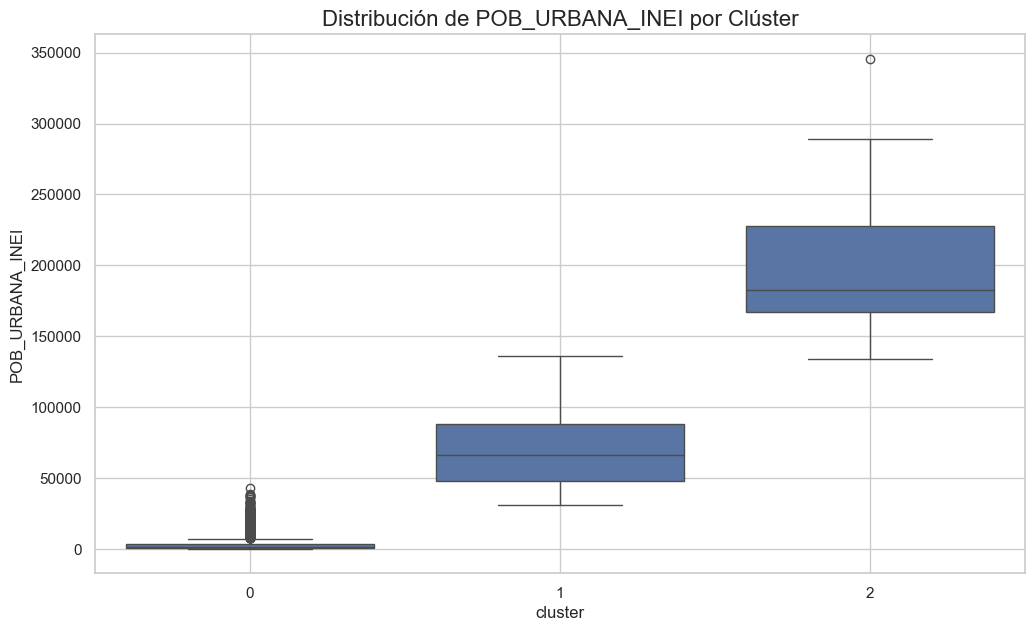

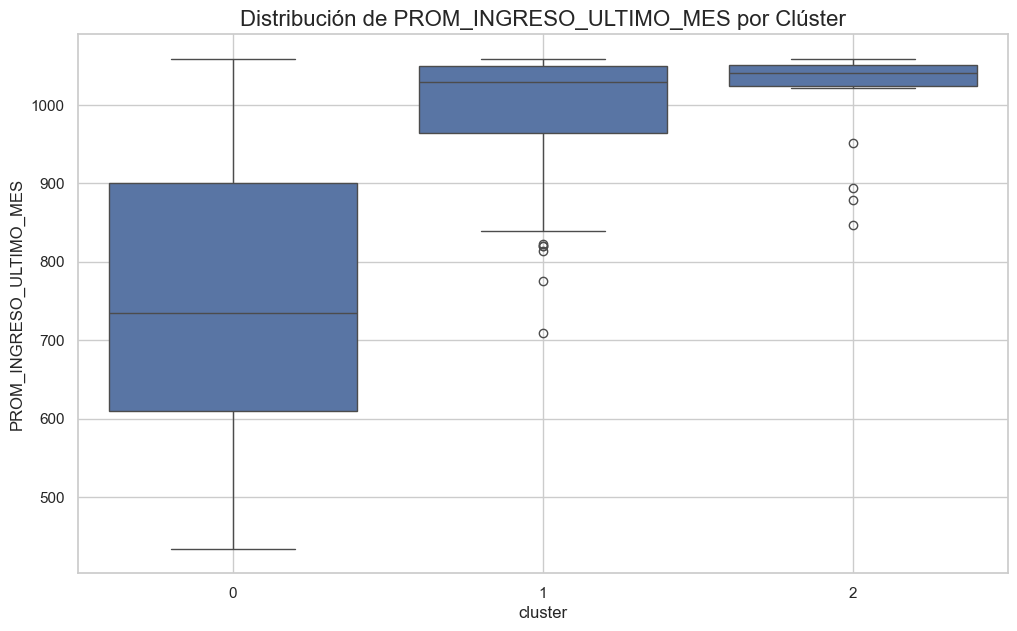

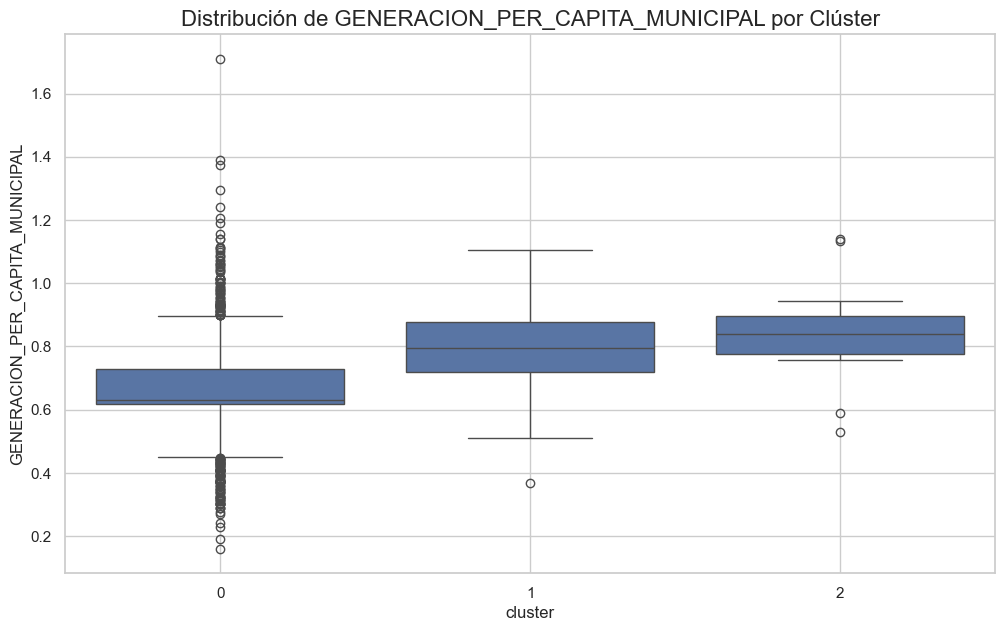

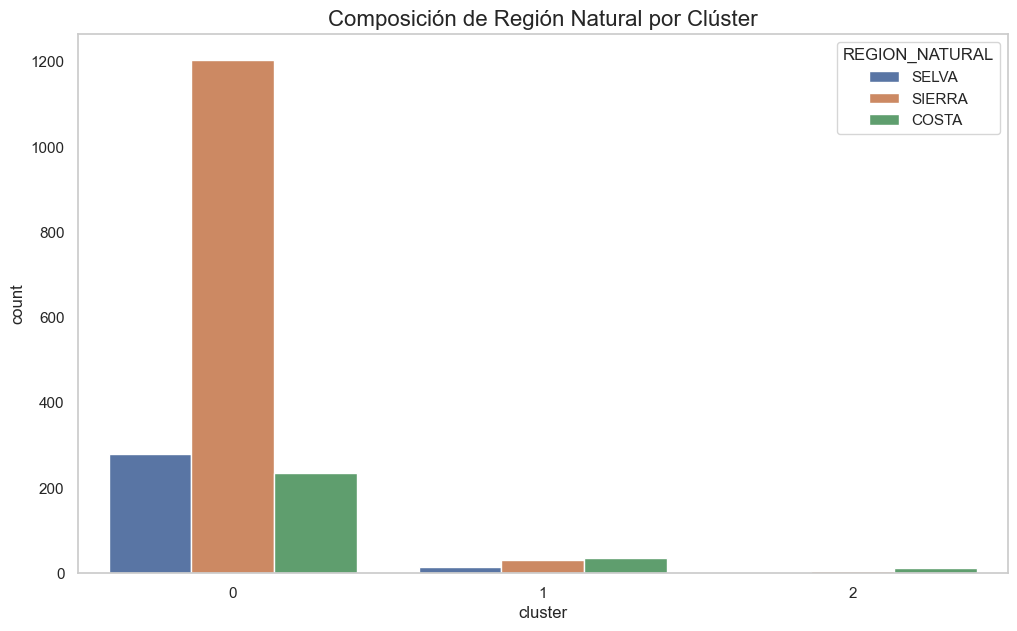

In [131]:
#Visualización de Características por Clúster

#Boxplots para comparar la distribución de variables clave
for feature in ['POB_URBANA_INEI', 'PROM_INGRESO_ULTIMO_MES', 'GENERACION_PER_CAPITA_MUNICIPAL']:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_original, x='cluster', y=feature)
    plt.title(f'Distribución de {feature} por Clúster', fontsize=16)
    plt.grid(True)
    plt.show()

#Count plot para variables categóricas
plt.figure(figsize=(12, 7))
sns.countplot(data=df_original, x='cluster', hue='REGION_NATURAL')
plt.title('Composición de Región Natural por Clúster', fontsize=16)
plt.grid(axis='y')
plt.show()

In [132]:
#ANÁLISIS DETALLADO Y PERFILADO DE CADA CLÚSTER

# Definir las variables numéricas clave para el análisis del perfil
numeric_features_for_analysis = [
    'POB_URBANA_INEI', 'POB_RURAL_INEI', 'GENERACION_PER_CAPITA_MUNICIPAL',
    'GENERACION_MUN_TANIO', 'PROM_GASTO_ULTIMO_MES_ALIMENTOS',
    'PROM_INGRESO_ULTIMO_MES', 'FUNCION_NOMBRE_%_TOTAL'
]

# Obtener la lista ordenada de clústeres para analizar
sorted_clusters = sorted(df_original['cluster'].unique())

In [133]:
#Iterar a través de cada ID de clúster
for cluster_id in sorted_clusters:
    # Imprimir un encabezado claro para cada clúster
    print(f" REPORTE DEL CLÚSTER   {cluster_id}")

    #Filtrar el DataFrame para obtener solo los datos del clúster actual
    cluster_df = df_original[df_original['cluster'] == cluster_id]
    
    #COMPOSICIÓN Y DEMOGRAFÍA
    print("\nComposición y Demografía del Clúster")
    num_distritos = len(cluster_df)
    print(f"   - Número de Distritos en este clúster: {num_distritos}")
    
    #Mostrar una muestra de los distritos
    distritos_muestra = cluster_df['DISTRITO'].head(10).tolist()
    print(f"   - Muestra de Distritos: {', '.join(distritos_muestra)}")

    #Analizar la composición de CLASIFICACION_MUNICIPAL_MEF
    print("\nDesglose por Clasificación Municipal (MEF):")
    mef_counts = cluster_df['CLASIFICACION_MUNICIPAL_MEF'].value_counts(normalize=True).mul(100).round(1)
    print(mef_counts.to_string())

    #Analizar la composición de REGION_NATURAL
    print("\nDesglose por Región Natural:")
    region_counts = cluster_df['REGION_NATURAL'].value_counts(normalize=True).mul(100).round(1)
    print(region_counts.to_string())

    #PERFIL NUMÉRICO DETALLADO
    print("\nPerfil Numérico (Estadísticas Descriptivas)")
    # Mostrar un resumen estadístico de las variables clave para este clúster
    print(cluster_df[numeric_features_for_analysis].describe().T)

    #INTERPRETACIÓN DEL CLÚSTER
    print("\nInterpretación y 'Personalidad' del Clúster")
    # Generar una descripción cualitativa basada en las medianas
    profile = cluster_df[numeric_features_for_analysis].median()
    
    # Lógica para crear una descripción simple comparando con la mediana global
    desc_pob_urbana = "alta" if profile['POB_URBANA_INEI'] > df_original['POB_URBANA_INEI'].median() else "baja"
    desc_pob_rural = "alta" if profile['POB_RURAL_INEI'] > df_original['POB_RURAL_INEI'].median() else "baja"
    desc_ingreso = "alto" if profile['PROM_INGRESO_ULTIMO_MES'] > df_original['PROM_INGRESO_ULTIMO_MES'].median() else "bajo"
    desc_gpc = "alta" if profile['GENERACION_PER_CAPITA_MUNICIPAL'] > df_original['GENERACION_PER_CAPITA_MUNICIPAL'].median() else "baja"
    desc_presupuesto = "alto" if profile['FUNCION_NOMBRE_%_TOTAL'] > df_original['FUNCION_NOMBRE_%_TOTAL'].median() else "bajo"
    
    print(f"   Este clúster se caracteriza por tener una población urbana {desc_pob_urbana},")
    print(f"   población rural {desc_pob_rural}, un ingreso promedio {desc_ingreso}, y una generación")
    print(f"   de residuos per cápita {desc_gpc}. Además, destinan una porción {desc_presupuesto}")
    print(f"   de su presupuesto a la gestión de residuos.")
    print(f"   La clasificación MEF más común es '{mef_counts.idxmax()}' y geográficamente")
    print(f"   predomina la región '{region_counts.idxmax()}'.")

 REPORTE DEL CLÚSTER   0

Composición y Demografía del Clúster
   - Número de Distritos en este clúster: 1720
   - Muestra de Distritos: CHACHAPOYAS, ASUNCION, BALSAS, CHETO, CHILIQUIN, CHUQUIBAMBA, GRANADA, HUANCAS, LA JALCA, LEIMEBAMBA

Desglose por Clasificación Municipal (MEF):
CLASIFICACION_MUNICIPAL_MEF
G    36.0
F    29.5
E    22.0
B     7.1
D     4.0
A     1.3

Desglose por Región Natural:
REGION_NATURAL
SIERRA    70.0
SELVA     16.3
COSTA     13.7

Perfil Numérico (Estadísticas Descriptivas)
                                  count         mean          std         min         25%          50%          75%          max
POB_URBANA_INEI                  1720.0  3587.439390  6257.776781   53.750000  462.375000  1119.875000  3216.625000  42558.50000
POB_RURAL_INEI                   1720.0  3029.253924  4389.625265    0.000000  466.500000  1496.125000  3653.750000  46964.25000
GENERACION_PER_CAPITA_MUNICIPAL  1720.0     0.656792     0.139355    0.160000    0.617500     0.630000     


Visualización de Distribuciones Internas del Clúster


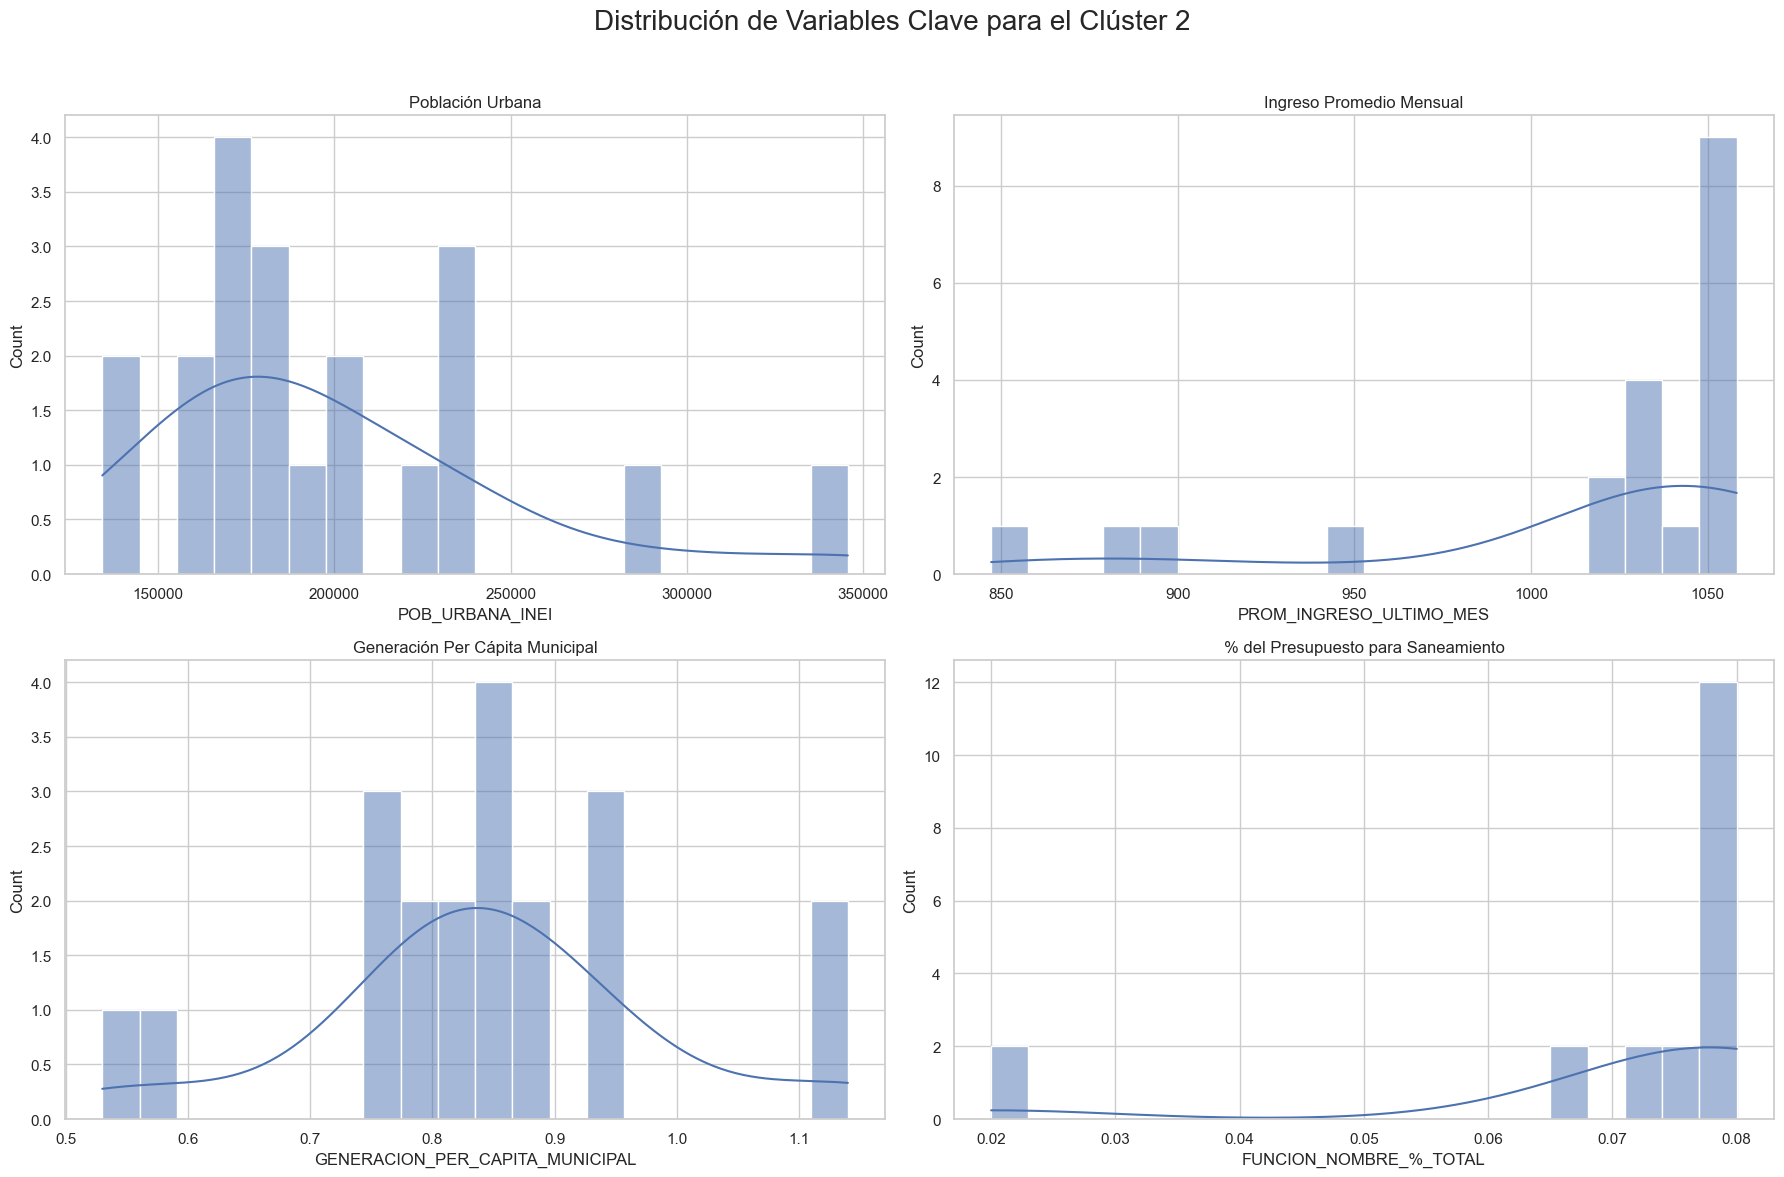

In [134]:
    #VISUALIZACIÓN DE DISTRIBUCIONES INTERNAS
    print("\nVisualización de Distribuciones Internas del Clúster")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Distribución de Variables Clave para el Clúster {cluster_id}', fontsize=20)
    sns.histplot(cluster_df['POB_URBANA_INEI'], kde=True, ax=axes[0, 0], bins=20).set_title('Población Urbana')
    sns.histplot(cluster_df['PROM_INGRESO_ULTIMO_MES'], kde=True, ax=axes[0, 1], bins=20).set_title('Ingreso Promedio Mensual')
    sns.histplot(cluster_df['GENERACION_PER_CAPITA_MUNICIPAL'], kde=True, ax=axes[1, 0], bins=20).set_title('Generación Per Cápita Municipal')
    sns.histplot(cluster_df['FUNCION_NOMBRE_%_TOTAL'], kde=True, ax=axes[1, 1], bins=20).set_title('% del Presupuesto para Saneamiento')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [76]:
df_original

UBIGEO  POB_URBANA_INEI  POB_RURAL_INEI  GENERACION_PER_CAPITA_MUNICIPAL  GENERACION_MUN_TANIO  PROM_GASTO_ULTIMO_MES_ALIMENTOS  PROM_INGRESO_ULTIMO_MES  FUNCION_NOMBRE_%_TOTAL DEPARTAMENTO    PROVINCIA                DISTRITO REGION_NATURAL CLASIFICACION_MUNICIPAL_MEF    latitud   longitud  POB_TOTAL_INEI  cluster
0      10101         38367.00          854.50                           0.6450             8980.8325                       318.058247               890.580156                0.043929     AMAZONAS  CHACHAPOYAS             CHACHAPOYAS          SELVA                           A  -6.247736 -77.856492        39221.50        3
1      10102           138.50          139.50                           0.7500               38.1000                       290.514953               660.584426                0.071409     AMAZONAS  CHACHAPOYAS                ASUNCION          SELVA                           F  -5.996135 -77.743201          278.00        0
2      10103           306.00          871.25                           0.6300               70.1650                       286.245651               631.129873                0.031470     AMAZONAS  CHACHAPOYAS                  BALSAS         SIERRA                           G  -6.807839 -77.949422         1177.25        0
3      10104           455.50          247.00                           0.6300              104.4775                       320.793045               855.827737                0.033414     AMAZONAS  CHACHAPOYAS                   CHETO         SIERRA                           F  -6.297970 -77.677166          702.50        0
4      10105           161.50          425.75                           0.6300               37.0300                       288.237105               639.810399                0.031545     AMAZONAS  CHACHAPOYAS               CHILIQUIN         SIERRA                           G  -6.078207 -77.755868          587.25        0
...      ...              ...             ...                              ...                   ...                              ...                      ...                     ...          ...          ...                     ...            ...                         ...        ...        ...             ...      ...
1867  250302          7695.50         4539.00                           0.6825             1923.3725                       305.809596               723.324352                0.051956      UCAYALI   PADRE ABAD                 IRAZOLA          SELVA                           F  -8.950516 -75.279918        12234.50        0
1868  250303          4887.75         5501.25                           0.7925             1416.4300                       284.487798               647.367008                0.077923      UCAYALI   PADRE ABAD                CURIMANA          SELVA                           F  -8.417380 -75.297114        10389.00        0
1869  250304          5208.50         5464.25                           0.8200             1557.1150                       283.565928               655.967308                0.074132      UCAYALI   PADRE ABAD                 NESHUYA          SELVA                           F  -8.641299 -75.049031        10672.75        0
1870  250305          4760.25         1451.75                           0.6725             1176.7175                       312.897414               788.907927                0.049662      UCAYALI   PADRE ABAD  ALEXANDER VON HUMBOLDT          SELVA                           E  -8.824928 -75.048021         6212.00        0
1871  250401          1368.00         1920.00                           0.7500              376.1150                       283.218197               621.287209                0.070999      UCAYALI        PURUS                   PURUS          SELVA                           B -10.373495 -71.582316         3288.00        0

[1822 rows x 17 columns]

# **COMPARACIÓN DE DOS MODELOS DE REGRESIÓN: XGBOOS Y RANDOMFOREST**

# *Primero probamos el rendimiento de XGboost*

In [ ]:
#MODELO DE REGRESIÓN CON XGBOOS
#Definir la variable objetivo (y) y las predictoras (X) 
TARGET = 'GENERACION_MUN_TANIO'

# NOTA CRÍTICA SOBRE LA FUGA DE DATOS (DATA LEAKAGE) 
# No debemos usar 'GENERACION_PER_CAPITA_MUNICIPAL' como predictor porque la variable objetivo
# (GENERACION_MUN_TANIO) se calcula directamente a partir de ella. El modelo aprendería una simple
# fórmula matemática en lugar de patrones reales. Esto se conoce como "fuga de datos".
# También excluimos POB_URBANA y POB_RURAL para evitar multicolinealidad con POB_TOTAL. TAMBIEN DROPEAREMOS 
features_to_drop = [
    TARGET, 'GENERACION_PER_CAPITA_MUNICIPAL', 'UBIGEO', 'PROVINCIA', 'DISTRITO',
    'POB_URBANA_INEI','POB_RURAL_INEI', 'POB_TOTAL_INEI','latitud', 'longitud','DEPARTAMENTO',
]
X = df_agg.drop(columns=features_to_drop) #GENERACION_MUN_TANIO, CLASIFICACION_MUNICIPAL_MEF, REGION_NATURAL,
#FUNCION_NOMBRE_%_TOTAL, PROM_INGRESO, PROM_GASTO_
y = df_agg[TARGET]

print(f"Variable a predecir (y): {TARGET}")
print(f"Variables predictoras (X): {X.columns.tolist()}")

#Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"   Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")


In [ ]:

#CREACIÓN DEL PIPELINE DE PREPROCESAMIENTO Y MODELADO


# Identificar columnas numéricas y categóricas para el preprocesamiento
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

#Creamos un pipeline de preprocesamiento robusto
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
#Definir el modelo de regresión (XGBoost)
regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1,
                             max_depth=5, random_state=42)

#Unir preprocesador y modelo en un único pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])


In [ ]:
#ENTRENAMIENTO DEL MODELO
pipeline.fit(X_train, y_train)
print("   Modelo entrenado.")

In [ ]:

#EVALUACIÓN DEL MODELO

#Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

#Calcular métricas de evaluación
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- Métricas de Desempeño ---")
print(f"R-cuadrado (R²): {r2:.4f}")
print(f"(Interpretación: El modelo explica aproximadamente el {r2:.1%} de la variabilidad en la generación de residuos).")
print(f"Error Absoluto Medio (MAE): {mae:,.2f} Toneladas/Año")
print(f"(Interpretación: En promedio, las predicciones del modelo se desvían en {mae:,.2f} toneladas del valor real).")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:,.2f} Toneladas/Año")
print(f"(Interpretación: Similar al MAE, pero penaliza más los errores grandes).")


In [ ]:
#Visualización de Predicciones vs. Valores Reales
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Predicciones del Modelo vs. Valores Reales', fontsize=18)
plt.xlabel('Generación Real (Toneladas/Año)', fontsize=12)
plt.ylabel('Generación Predicha (Toneladas/Año)', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
#INTERPRETACIÓN DEL MODELO - IMPORTANCIA DE VARIABLES

#Extraer la importancia de las variables del modelo entrenado dentro del pipeline
model_in_pipeline = pipeline.named_steps['regressor']
preprocessor_in_pipeline = pipeline.named_steps['preprocessor']

#Obtener los nombres de las columnas después del One-Hot Encoding
encoded_cat_features = preprocessor_in_pipeline.named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_features)

#Crear un DataFrame de importancia
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': model_in_pipeline.feature_importances_
}).sort_values('importance', ascending=False).head(15) # Top 15

#Visualizar la importancia de las variables
plt.figure(figsize=(12, 9))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 15 Variables Más Importantes para Predecir la Generación de Residuos XGBOOT', fontsize=18)
plt.xlabel('Importancia Relativa')
plt.ylabel('Variable')
plt.grid(axis='x')
plt.show()

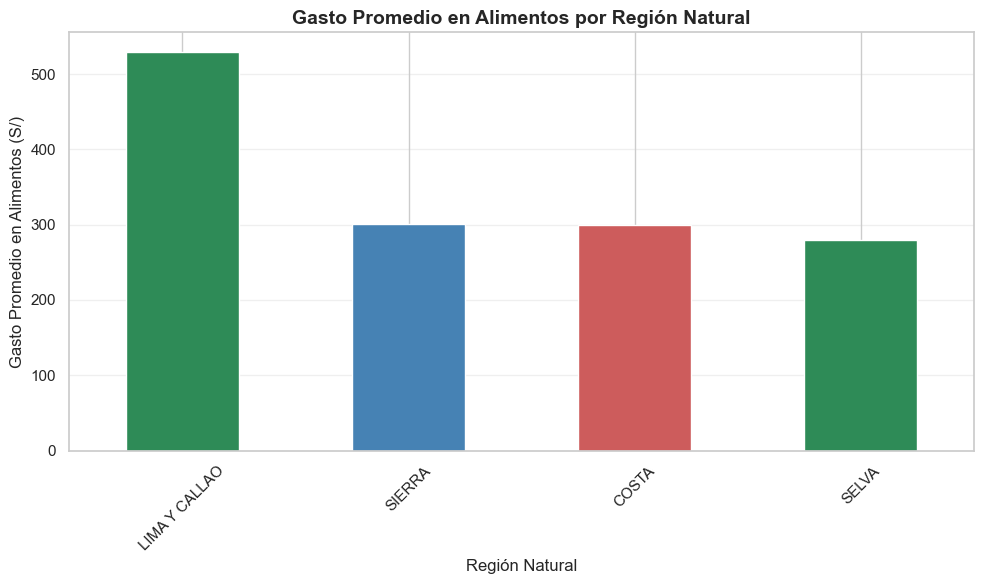

In [59]:
# Gráfico de gasto en alimentos por región natural
plt.figure(figsize=(10, 6))
df_agg.groupby('REGION_NATURAL')['PROM_GASTO_ULTIMO_MES_ALIMENTOS'].mean().sort_values(ascending=False).plot(kind='bar', color=['#2E8B57', '#4682B4', '#CD5C5C'])
plt.title('Gasto Promedio en Alimentos por Región Natural', fontsize=14, fontweight='bold')
plt.xlabel('Región Natural')
plt.ylabel('Gasto Promedio en Alimentos (S/)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# *XGboost vs RandomForest*

In [ ]:
#MODELO DE REGRESIÓN CON RANDOMFORESTREGRESOR COMPARACIÓN CON EL ANTERIOR 

#Para este caso elegimos las mismas variables predictoras y mismas condiciones para medir el rendimiento de los modelos
TARGET = 'GENERACION_MUN_TANIO'
features_to_drop = [
    TARGET, 'GENERACION_PER_CAPITA_MUNICIPAL', 'UBIGEO', 'PROVINCIA', 'DISTRITO',
    'POB_URBANA_INEI', 'POB_RURAL_INEI', 'POB_TOTAL_INEI','latitud', 'longitud','DEPARTAMENTO',
]
X = df_agg.drop(columns=features_to_drop)
y = df_agg[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"   Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")


In [ ]:
#DEFINICIÓN DEL PIPELINE DE PREPROCESAMIENTO

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])
print("   Pipeline de preprocesamiento definido.")

In [ ]:
#Entrenamos ambos modelos (El XGBOOST ya se provó previamente, pero repetimos para hacer la comparación)

models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

In [ ]:
#OBTENEMOS LAS METRICAS PARA CADA MODELO. EN EL CASO DE REGRESIÓN EVALUAMOS R2 Y ERRORES
for name, model in models.items():
    print(f"\n--- Entrenando modelo: {name} ---")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R²': r2, 'MAE': mae, 'RMSE': rmse}
    print(f"Evaluación de {name}:")
    print(f"R-cuadrado (R²): {r2:.4f}")
    print(f"Error Absoluto Medio (MAE): {mae:,.2f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:,.2f}")


In [ ]:
#top variables importantes para el modelo de random forest
#Crear un DataFrame de importancia
#Extraer la importancia de las variables del modelo entrenado dentro del pipeline
model_in_pipeline = pipeline.named_steps['regressor']
preprocessor_in_pipeline = pipeline.named_steps['preprocessor']

#Obtener los nombres de las columnas después del One-Hot Encoding
encoded_cat_features = preprocessor_in_pipeline.named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_features)

#Crear un DataFrame de importancia
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': model_in_pipeline.feature_importances_
}).sort_values('importance', ascending=False).head(15) # Top 15

#Visualizar la importancia de las variables
plt.figure(figsize=(12, 9))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 15 Variables Más Importantes para Predecir la Generación de Residuos RandomForest', fontsize=18)
plt.xlabel('Importancia Relativa')
plt.ylabel('Variable')
plt.grid(axis='x')
plt.show()

In [ ]:
#COMPARACIÓN FINAL DE MODELOS

# DataFrame con los datos numéricos originales para graficar
results_to_plot = pd.DataFrame(results).T.sort_values(by='R²', ascending=False)

# Creamos una copia para darle formato y mostrarla en la tabla
display_df = results_to_plot.copy()
display_df['R²'] = display_df['R²'].map('{:.4f}'.format)
display_df['MAE'] = display_df['MAE'].map('{:,.2f}'.format)
display_df['RMSE'] = display_df['RMSE'].map('{:,.2f}'.format)

print("\nTabla Comparativa de Métricas de Desempeño")
print(display_df)


In [ ]:
#Visualización de la Comparación
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Comparación de Métricas de Modelos de Regresión', fontsize=20)

# Gráfico para R² (más alto es mejor) - Usamos results_to_plot
results_to_plot['R²'].sort_values(ascending=False).plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('R-cuadrado (R²)', fontsize=14)
axes[0].set_ylabel('Puntaje R²')
axes[0].tick_params(axis='x', rotation=0)
axes[0].set_ylim(bottom=max(0, results_to_plot['R²'].min() - 0.05), top=1.0)
axes[0].grid(axis='y', linestyle='--')

# Gráfico para MAE (más bajo es mejor) - Usamos results_to_plot
results_to_plot['MAE'].sort_values(ascending=True).plot(kind='bar', ax=axes[1], color=['salmon', 'skyblue'])
axes[1].set_title('Error Absoluto Medio (MAE)', fontsize=14)
axes[1].set_ylabel('Toneladas/Año')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', linestyle='--')

# Gráfico para RMSE (más bajo es mejor) - Usamos results_to_plot
results_to_plot['RMSE'].sort_values(ascending=True).plot(kind='bar', ax=axes[2], color=['salmon', 'skyblue'])
axes[2].set_title('Raíz del Error Cuadrático Medio (RMSE)', fontsize=14)
axes[2].set_ylabel('Toneladas/Año')
axes[2].tick_params(axis='x', rotation=0)
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# *Probamos un modelo clasificador (dada la naturaleza del dataset se espera clases no balanceadas y recall demasiado elevado en la clasificación C)*

   Variable a predecir (y): CLASIFICACION_MUNICIPAL_MEF
   Variables predictoras (X): ['GENERACION_PER_CAPITA_MUNICIPAL', 'GENERACION_MUN_TANIO', 'PROM_GASTO_ULTIMO_MES_ALIMENTOS', 'PROM_INGRESO_ULTIMO_MES', 'FUNCION_NOMBRE_%_TOTAL', 'REGION_NATURAL']
   Datos divididos: 1497 para entrenamiento, 375 para prueba.
CLASIFICACION_MUNICIPAL_MEF
G    33.132933
F    27.120908
E    20.173681
D     6.813627
B     6.546426
A     3.941216
C     2.271209
Name: proportion, dtype: float64
   ADVERTENCIA: Las clases parecen estar desbalanceadas.
   El modelo usará 'class_weight=balanced' para mitigar este efecto.
              precision    recall  f1-score   support

           A       0.73      0.53      0.62        15
           B       0.44      0.29      0.35        24
           C       0.73      1.00      0.84         8
           D       0.62      0.58      0.60        26
           E       0.82      0.88      0.85        76
           F       0.90      0.97      0.93       102
           G   

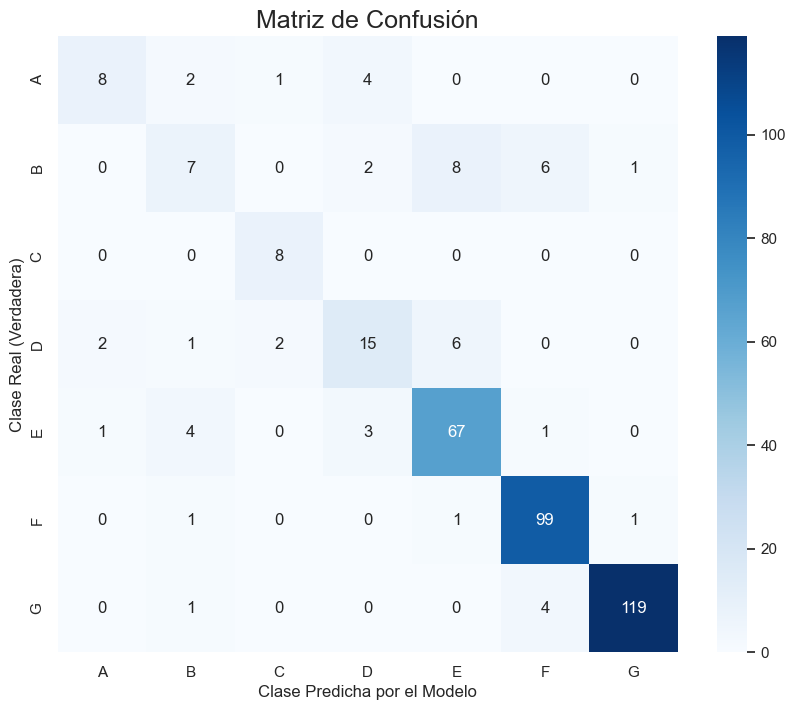

Interpretación de la Matriz: La diagonal principal (de arriba-izquierda a abajo-derecha) muestra
las predicciones correctas. Los números fuera de la diagonal son los errores de clasificación.


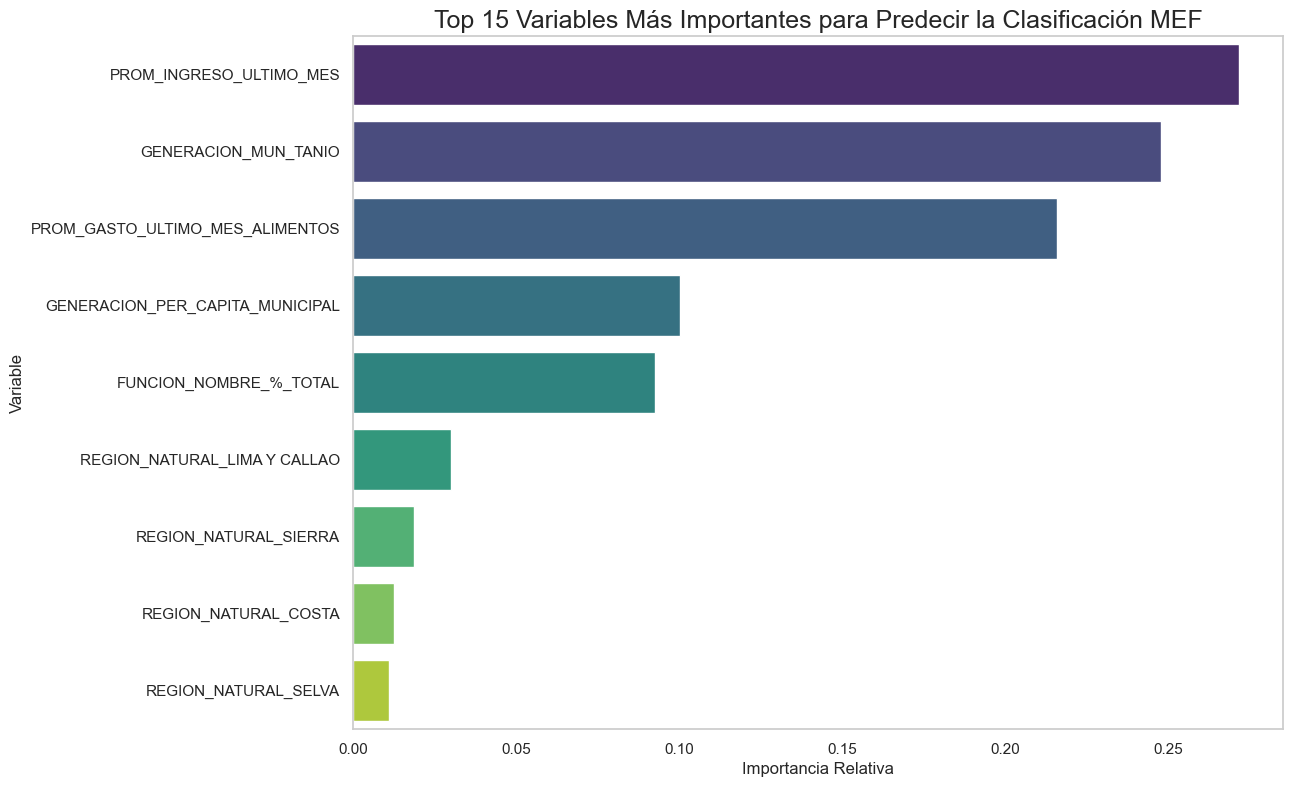

In [138]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

#Definir la variable objetivo (y) y las predictoras (X)
TARGET = 'CLASIFICACION_MUNICIPAL_MEF'

# Excluimos identificadores y variables que no aportan al problema de clasificación
features_to_drop = [TARGET, 'UBIGEO', 'PROVINCIA', 'DISTRITO','POB_TOTAL_INEI','POB_URBANA_INEI','POB_RURAL_INEI','longitud','latitud','DEPARTAMENTO']
X = df_agg.drop(columns=features_to_drop)
y = df_agg[TARGET]

print(f"   Variable a predecir (y): {TARGET}")
print(f"   Variables predictoras (X): {X.columns.tolist()}")

#Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
#Usamos stratify=y para asegurar que la proporción de clases sea la misma en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"   Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

#REVISAMOS EL DESBALANCE DE CLASES
class_distribution = y_train.value_counts(normalize=True) * 100
print(class_distribution)
if class_distribution.min() < 10 or class_distribution.max() > 40:
    print("   ADVERTENCIA: Las clases parecen estar desbalanceadas.")
    print("   El modelo usará 'class_weight=balanced' para mitigar este efecto.")
else:
    print("   Las clases parecen estar razonablemente balanceadas.")



#Elaboramos el pipeline de procesamiento
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

# Definir el modelo clasificador
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

# Unir preprocesador y modelo en un único pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
#entramos el modelo 

pipeline.fit(X_train, y_train)

#evaluemos el modelo
y_pred = pipeline.predict(X_test)
class_labels = sorted(y_test.unique())

print(classification_report(y_test, y_pred, labels=class_labels))
print("Interpretación de Métricas:")
print(" - Precision: De todas las veces que el modelo predijo una clase, ¿qué porcentaje fue correcto?")
print(" - Recall (Sensibilidad): De todos los casos reales de una clase, ¿qué porcentaje detectó el modelo?")
print(" - F1-Score: Media armónica de Precision y Recall. Un buen balance entre ambas.")
print(f"\n- Exactitud (Accuracy) General: {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Matriz de Confusión ---")
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión', fontsize=18)
plt.ylabel('Clase Real (Verdadera)')
plt.xlabel('Clase Predicha por el Modelo')
plt.show()
print("Interpretación de la Matriz: La diagonal principal (de arriba-izquierda a abajo-derecha) muestra")
print("las predicciones correctas. Los números fuera de la diagonal son los errores de clasificación.")


#Interpretación e importancia de las variables 

model_in_pipeline = pipeline.named_steps['classifier']
preprocessor_in_pipeline = pipeline.named_steps['preprocessor']
encoded_cat_features = preprocessor_in_pipeline.named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_features)

feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': model_in_pipeline.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# Visualizar la importancia
plt.figure(figsize=(12, 9))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Top 15 Variables Más Importantes para Predecir la Clasificación MEF', fontsize=18)
plt.xlabel('Importancia Relativa')
plt.ylabel('Variable')
plt.grid(axis='x')
plt.show()



In [ ]:
#SE CONFIRMA LO ESPERADO Y SE DECIDE NO APLICAR ESTA TAREA. SE MENCIONARÁ EN LA EXPOSICIÓN COMO OPORTUNIDAD DE MEJORA.